https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import re

from scipy import stats
from scipy.special import boxcox, inv_boxcox

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import mutual_info_classif

import time
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import _tree
from sklearn import tree

from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, precision_recall_curve
from sklearn.model_selection import GridSearchCV

from bayes_opt import BayesianOptimization

from sklearn import metrics

import shap

### Functions

In [2]:
#########################
### Feature selection ###
#########################

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [3]:
############################################
### Data sub populations from tree model ###
############################################

def get_rules(tree, feature_names, class_names, perc_thold = 80, sample_thold = 100):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    proba = []
    samples = []
    for path in paths:
        #print(path)
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"

        if (np.round(100.0*classes[l]/np.sum(classes),2) > perc_thold) & (path[-1][1] > sample_thold):
            rules += [rule]
            proba += [np.round(100.0*classes[l]/np.sum(classes),2)]            
        
    return rules, proba

In [4]:
#############################
### New interaction terms ###
#############################

def new_f(new_name, name, var, cvar):
    X_train[new_name] = 0
    X_train.loc[X_train[cvar] == name, new_name] = X_train[var]
    X_test[new_name] = 0
    X_test.loc[X_test[cvar] == name, new_name] = X_test[var]

In [5]:
#################################
### Variance inflation factor ###
#################################

def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [6]:
##############################
### Min-Max transformation ###
##############################

def minmax_dset(dset,numeric_columns):

    dseta = dset.copy()
    dsetb = pd.DataFrame(transformer_train.transform(dseta[numeric_columns]))
    dsetb.columns = numeric_columns
    print(dsetb.shape)
    return dsetb

In [7]:
########################
### One hot encoding ###
########################

def ohe_dset(dset,categorical_columns):

    dseta = dset.copy()
    transformed_dset = ohe.fit_transform(dseta[categorical_columns])
    cat_data = pd.DataFrame(transformed_dset.toarray())
    cat_data.columns = ohe.get_feature_names_out(input_features=dseta[categorical_columns].columns)
    print(cat_data.shape)
    return cat_data

In [8]:
#######################
### Model selection ###
#######################

def select_model(X, y, pipeline=None):
    """Test a range of classifiers and return their performance metrics on training data.

    Args:
        X (object): Pandas dataframe containing X_train data.
        y (object): Pandas dataframe containing y_train data.
        pipeline (object): Pipeline from get_pipeline().

    Return:
        df (object): Pandas dataframe containing model performance data.
    """

    classifiers = {}
    classifiers.update({"DummyClassifier": DummyClassifier(strategy='most_frequent')})
    classifiers.update({"LGBMClassifier": LGBMClassifier()})
    classifiers.update({"ExtraTreeClassifier": ExtraTreeClassifier()})
    classifiers.update({"RidgeClassifier": RidgeClassifier()})
    classifiers.update({"BernoulliNB": BernoulliNB()})
    classifiers.update({"SGDClassifier": SGDClassifier()})
    classifiers.update({"AdaBoostClassifier": AdaBoostClassifier()})     
    classifiers.update({"CatBoostClassifier":CatBoostClassifier(silent=True)})    
    classifiers.update({"XGBClassifier": XGBClassifier(use_label_encoder=False,
                                                       eval_metric='logloss',
                                                       objective='binary:logistic',
                                                     )})    
    classifiers.update({"DecisionTreeClassifier": DecisionTreeClassifier()})

    # Stacking
    models = []

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))

    # classifiers.update({"VotingClassifier (XGBClassifier, CatBoostClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('LGBMClassifier', LGBMClassifier()))
    # models.append(('CatBoostClassifier', CatBoostClassifier(silent=True)))
    # classifiers.update({"VotingClassifier (XGBClassifier, LGBMClassifier, CatBoostClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('RandomForestClassifier', RandomForestClassifier()))
    # models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
    # classifiers.update({"VotingClassifier (XGBClassifier, RandomForestClassifier, DecisionTreeClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('AdaBoostClassifier', AdaBoostClassifier()))
    # models.append(('ExtraTreeClassifier', ExtraTreeClassifier()))
    # classifiers.update({"VotingClassifier (XGBClassifier, AdaBoostClassifier, ExtraTreeClassifier)": VotingClassifier(models)})

    # models = []
    # models.append(('XGBClassifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', objective='binary:logistic')))
    # models.append(('ExtraTreesClassifier', ExtraTreesClassifier()))
    # classifiers.update({"VotingClassifier (XGBClassifier, ExtraTreesClassifier)": VotingClassifier(models)})

    #scoring = {'f1_score' : make_scorer(f1_score, average='weighted')}

    df_models = pd.DataFrame(columns=['model', 'run_time', 'accuracy'])
    
    for key in tqdm(classifiers):
        start_time = time.time()
        #pipeline = get_pipeline(X, classifiers[key])        

        pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), classifiers[key]) 

        cv = cross_val_score(pipeline, X, y, cv=5, scoring = 'roc_auc')
        row = {'model': key,
               'run_time': format(round((time.time() - start_time)/60,2)),
               'accuracy': cv.mean(),
        }
        row_df = pd.DataFrame(row, index=[0])

        df_models = pd.concat([df_models,
                                   row_df],
                                  axis=0,
                                  ignore_index=True)

        df_models = df_models.sort_values(by='accuracy', ascending=False)
    return df_models



In [186]:
######################################
### Catboost Hyperparameter tuning ###
######################################

def CB_opt(n_estimators, depth, learning_rate, max_bin,
    subsample, num_leaves, l2_leaf_reg, model_size_reg):
    catb_scores = []
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1944)
    for train_index, test_index in skf.split(X_train_mod, y_train):

        trainx, valx = X_train_mod.iloc[train_index], X_train_mod.iloc[test_index]
        trainy, valy = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[test_index]

        reg = CatBoostClassifier(verbose = 0,
                               n_estimators = int(n_estimators),
                               learning_rate = learning_rate,
                               subsample = subsample,
                               l2_leaf_reg = l2_leaf_reg,
                               max_depth = int(depth),
                               num_leaves = int(num_leaves),
                               random_state = 88,
                               grow_policy = "Lossguide",
                               max_bin = int(max_bin),
                               use_best_model = True,
                               model_size_reg = model_size_reg,
                               eval_metric = 'AUC'

                               )

        reg.fit(trainx, trainy, eval_set = (valx, valy))
        catb_scores.append(roc_auc_score(valy, reg.predict(valx)))
    return np.mean(catb_scores)

In [10]:
#################
### XGB Boost ###
#################

def xgbc_cv(max_depth,learning_rate,n_estimators,reg_alpha,reg_lambda,gamma):

    estimator_function = xgb.XGBClassifier(max_depth = int(max_depth),
                                               learning_rate = learning_rate,
                                               n_estimators = int(n_estimators),
                                               reg_alpha = reg_alpha,
                                               gamma = gamma,
                                               reg_lambda = reg_lambda,
                                               nthread = -1,
                                               objective = "binary:logistic",
                                               eval_metric = "auc",
                                               seed = seed)
    # Fit the estimator
    estimator_function.fit(X_train_mod, y_train)

    # calculate out-of-the-box roc_score using validation set 1
    probs = estimator_function.predict_proba(X_train_mod)
    probs = probs[:,1]
    val1_roc = roc_auc_score(y_train,probs)

    # calculate out-of-the-box roc_score using validation set 2
    probs = estimator_function.predict_proba(X_test)
    probs = probs[:,1]
    val2_roc = roc_auc_score(y_test,probs)

    # return the mean validation score to be maximized
    return np.array([val1_roc,val2_roc]).mean()

In [11]:
##################
### LGBM model ###
##################

def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):

    params = {'application':'binary', 'metric':'auc'}
    params['learning_rate'] = max(min(learning_rate, 1), 0)
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['max_bin'] = int(round(max_depth))
    params['min_data_in_leaf'] = int(round(min_data_in_leaf))
    params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
    params['subsample'] = max(min(subsample, 1), 0)

    cv_result = lgb.cv(params,
                           train_data,
                           nfold = 10,
                           seed = 6,
                           stratified = True,
                           verbose_eval = 200,
                           metrics = ['auc'])
    return max(cv_result['auc-mean'])

In [12]:
########################
### Confusion matrix ###
########################

def cm2df(cm, labels):
            df = pd.DataFrame()

            for i, row_label in enumerate(labels):
                rowdata={}
        
                for j, col_label in enumerate(labels): 
                    rowdata[col_label]=cm[i,j]
                df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
            return df[labels]

In [108]:
#########################
### Compare box plots ###
#########################

def boxplot_compare(target, var, num):
    fig, ax=plt.subplots(1, 2, figsize=(20, 7))
    d1 = df[df[target] == 'Yes']
    d1 = d1.sort_values([var])
    d2 = df[df[target] == 'No']
    d2 = d2.sort_values([var])
    g1 = sns.boxplot(data=d1, x=num, y=var, palette='rainbow', showmeans=True, ax=ax[0])
    g1.set_title("Churn Data")
    g1.set_xlim(0, max(df[num]) + 10)

    g2 = sns.boxplot(data=d2, x=num, y=var, palette='rainbow', showmeans=True, ax=ax[1])
    g2.set(ylabel=None)
    g2.set(yticklabels=[]) 
    g2.set_title("Non Churn Data")
    g2.set_xlim(0, max(df[num]) + 10)
    plt.show();

### Read in the data

In [13]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(data.shape)
data.head()

(7043, 21)


customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

In [14]:
data.describe()

SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

In [15]:
print(list(data.columns))

['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [16]:
nonvar_lst = []

for i in range(data.shape[1]):
    print('Column: ', data.columns[i], ', number of unique classes: ', data.iloc[:,i].nunique())
    if data.iloc[:,i].nunique() < 50:
        print('Values: ', list(set(data.iloc[:,i])))
    if data.iloc[:,i].nunique() == 1:
        nonvar_lst.append(data.columns[i])
        


Column:  customerID , number of unique classes:  7043
Column:  gender , number of unique classes:  2
Values:  ['Female', 'Male']
Column:  SeniorCitizen , number of unique classes:  2
Values:  [0, 1]
Column:  Partner , number of unique classes:  2
Values:  ['Yes', 'No']
Column:  Dependents , number of unique classes:  2
Values:  ['Yes', 'No']
Column:  tenure , number of unique classes:  73
Column:  PhoneService , number of unique classes:  2
Values:  ['Yes', 'No']
Column:  MultipleLines , number of unique classes:  3
Values:  ['Yes', 'No', 'No phone service']
Column:  InternetService , number of unique classes:  3
Values:  ['No', 'DSL', 'Fiber optic']
Column:  OnlineSecurity , number of unique classes:  3
Values:  ['Yes', 'No', 'No internet service']
Column:  OnlineBackup , number of unique classes:  3
Values:  ['Yes', 'No', 'No internet service']
Column:  DeviceProtection , number of unique classes:  3
Values:  ['Yes', 'No', 'No internet service']
Column:  TechSupport , number of uniqu

In [17]:
print(nonvar_lst)

[]


### Missing data

In [18]:
check = data.isnull().sum()
check = pd.DataFrame(check)
check.columns = ['Count']
check['perc'] = check.Count/data.shape[0]*100
check

Count  perc
customerID            0   0.0
gender                0   0.0
SeniorCitizen         0   0.0
Partner               0   0.0
Dependents            0   0.0
tenure                0   0.0
PhoneService          0   0.0
MultipleLines         0   0.0
InternetService       0   0.0
OnlineSecurity        0   0.0
OnlineBackup          0   0.0
DeviceProtection      0   0.0
TechSupport           0   0.0
StreamingTV           0   0.0
StreamingMovies       0   0.0
Contract              0   0.0
PaperlessBilling      0   0.0
PaymentMethod         0   0.0
MonthlyCharges        0   0.0
TotalCharges          0   0.0
Churn                 0   0.0

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Target variable

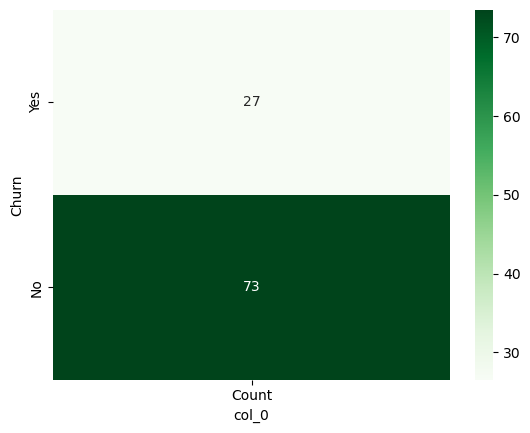

In [19]:
target_t = pd.DataFrame(pd.crosstab(data.Churn, columns = 'Count', normalize='columns'))
target_t = target_t * 100

ax = sns.heatmap(target_t, annot = True, cmap="Greens")
ax.invert_yaxis()

In [20]:
print('No churn', round(data['Churn'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Churn', round(data['Churn'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

No churn 73.46 % of the dataset
Churn 26.54 % of the dataset


### Adjust the training set

In [21]:
data = data.drop_duplicates()
print(data.shape)

(7043, 21)


In [41]:
pd.crosstab(data.TotalCharges, columns = 'Count')
pd.crosstab(data.TotalCharges == ' ', columns = 'Count')

col_0         Count
TotalCharges       
False          7032
True             11

In [128]:
df = data.copy()

df = df[df.TotalCharges != ' ']

for name in ['Partner','Dependents','PhoneService','PaperlessBilling','Churn']:
    df[name + '_n'] = (df[name] == 'Yes').astype(int)
    
df['gender_n'] = (df['gender'] == 'Male').astype(int)    

df.rename(columns={"SeniorCitizen": "SeniorCitizen_n"}, inplace = True)

for name in ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
             'Contract', 'PaymentMethod']:

    data[name] = data[name].str.replace('-','_')
    data[name] = data[name].str.replace(' ','_')
    data[name] = data[name].str.replace('(','')
    data[name] = data[name].str.replace(')','')

df.TotalCharges = df.TotalCharges.astype(float)

print(df.shape)
df.head()

(7032, 27)


The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


customerID  gender  SeniorCitizen_n Partner Dependents  tenure  \
0  7590-VHVEG  Female                0     Yes         No       1   
1  5575-GNVDE    Male                0      No         No      34   
2  3668-QPYBK    Male                0      No         No       2   
3  7795-CFOCW    Male                0      No         No      45   
4  9237-HQITU  Female                0      No         No       2   

  PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0           No  No phone service             DSL             No  ...   
1          Yes                No             DSL            Yes  ...   
2          Yes                No             DSL            Yes  ...   
3           No  No phone service             DSL            Yes  ...   
4          Yes                No     Fiber_optic             No  ...   

             PaymentMethod MonthlyCharges TotalCharges Churn Partner_n  \
0         Electronic_check          29.85        29.85    No         1   
1             Mailed_check          56.95      1889.50    No         0   
2             Mailed_check          53.85       108.15   Yes         0   
3  Bank_transfer_automatic          42.30      1840.75    No         0   
4         Electronic_check          70.70       151.65   Yes         0   

  Dependents_n PhoneService_n PaperlessBilling_n  Churn_n  gender_n  
0            0              0                  1        0         0  
1            0              1                  0        0         1  
2            0              1                  1        1         1  
3            0              0                  0        0         1  
4            0              1                  1        1         0  

[5 rows x 27 columns]

### Numerical data

In [44]:
print([col for col in df.columns if '_n' in col])

['SeniorCitizen_n', 'gender_n', 'Partner_n', 'Dependents_n', 'PhoneService_n', 'PaperlessBilling_n', 'Churn_n']


In [45]:
num_cols = list(df.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in df.columns if '_n' in col])))
print(num_cols)

['tenure', 'TotalCharges', 'MonthlyCharges']


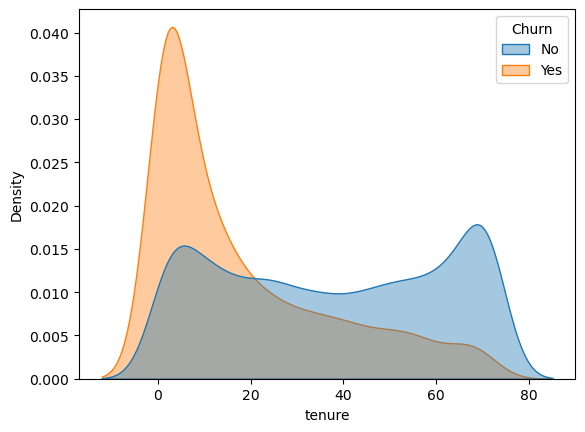

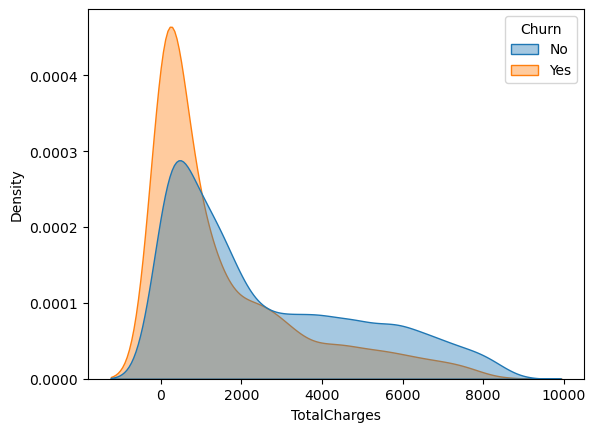

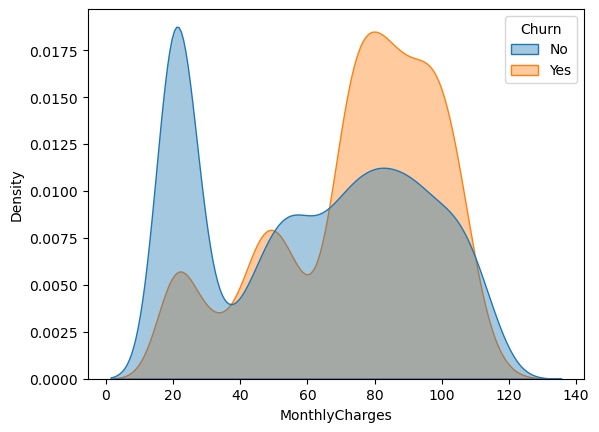

In [46]:
for name in num_cols:
    sns.kdeplot(data=df, x=name, hue="Churn", fill=True, common_norm=False, alpha=0.4)
    plt.show()

### Interaction terms

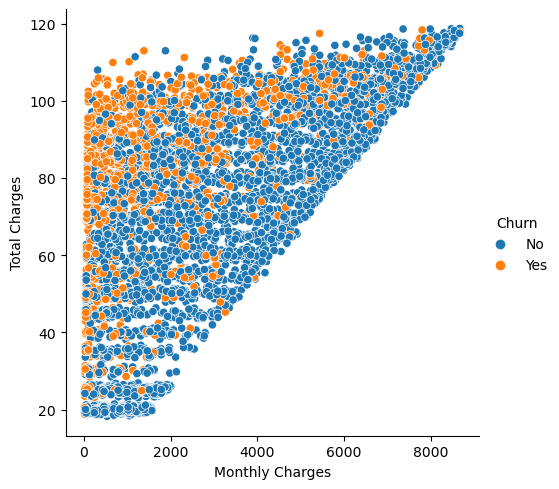

In [47]:
sns.relplot(x='TotalCharges',
            y='MonthlyCharges',
            data = df,
            kind='scatter',
            hue='Churn')
plt.ylabel("Total Charges")
plt.xlabel("Monthly Charges")
plt.show();

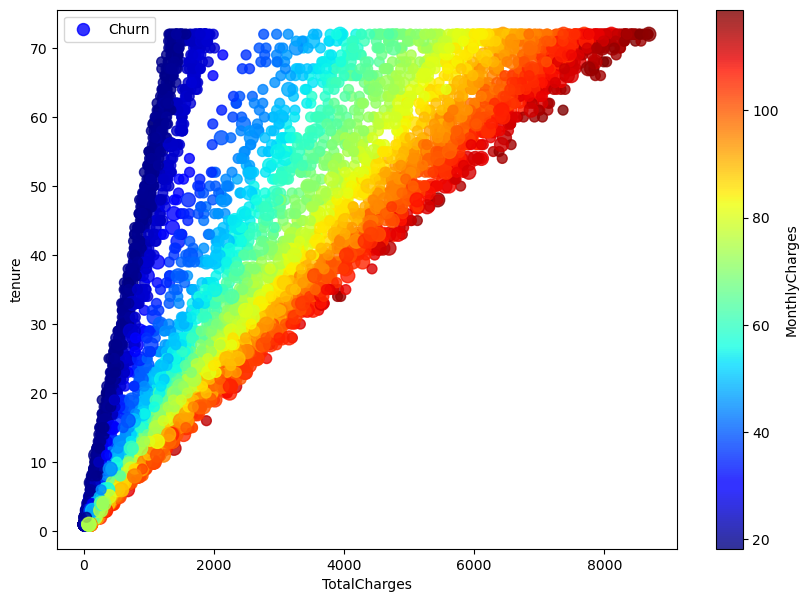

In [54]:
data_v = df.copy()
data_v["Churn_n"] = (data_v["Churn_n"] + 1) * 50
data_v["Churn_n"] = data_v["Churn_n"].astype(int)

data_v.plot(kind="scatter", x="TotalCharges", y="tenure", alpha=0.8,
             s=data_v["Churn_n"], label="Churn", figsize=(10,7),
             c="MonthlyCharges", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
plt.show();

In [ ]:
# Contract              0.096910
# tenure                0.083345
# OnlineSecurity        0.063449
# TechSupport           0.061518
# InternetService       0.052963
# MonthlyCharges        0.049854
# PaymentMethod         0.048688
# OnlineBackup          0.046357

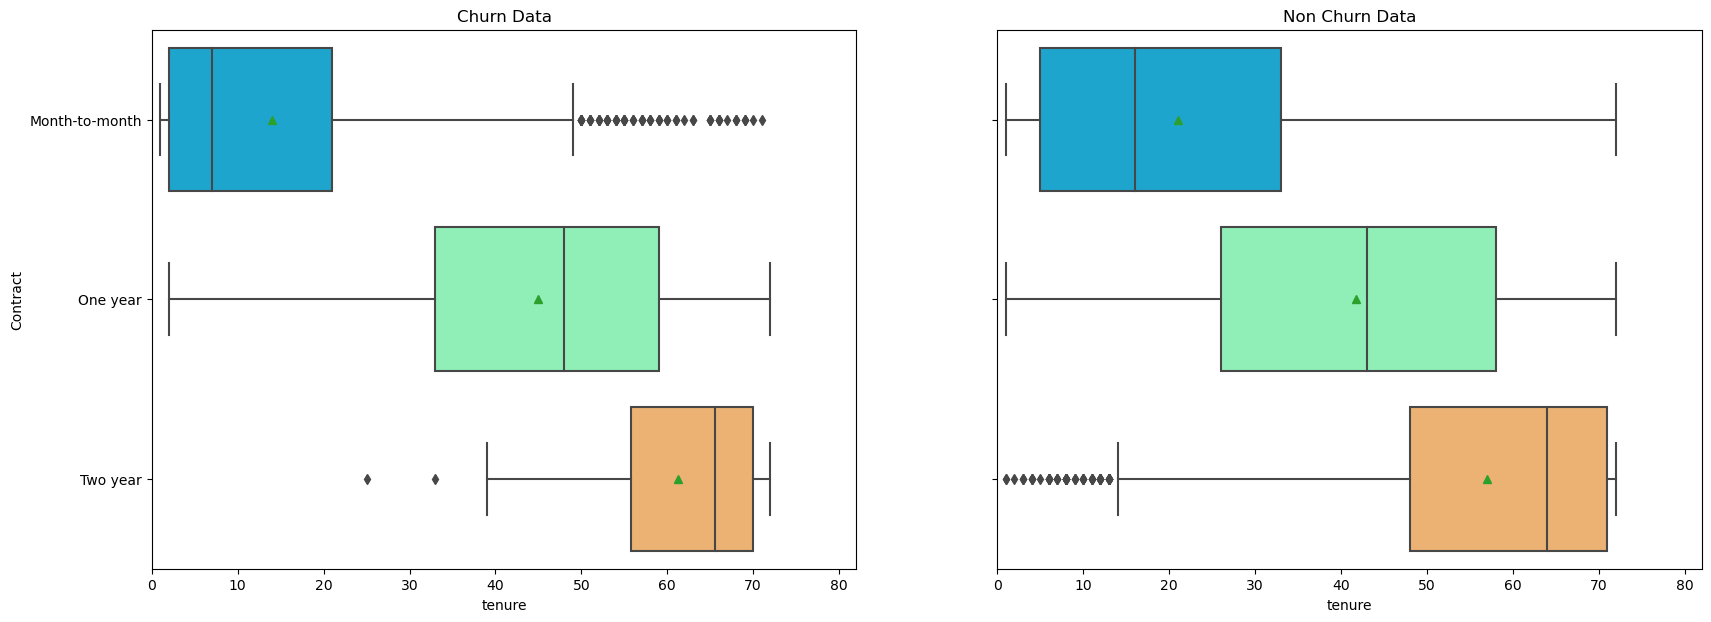

In [110]:
boxplot_compare('Churn', "Contract", "tenure")    

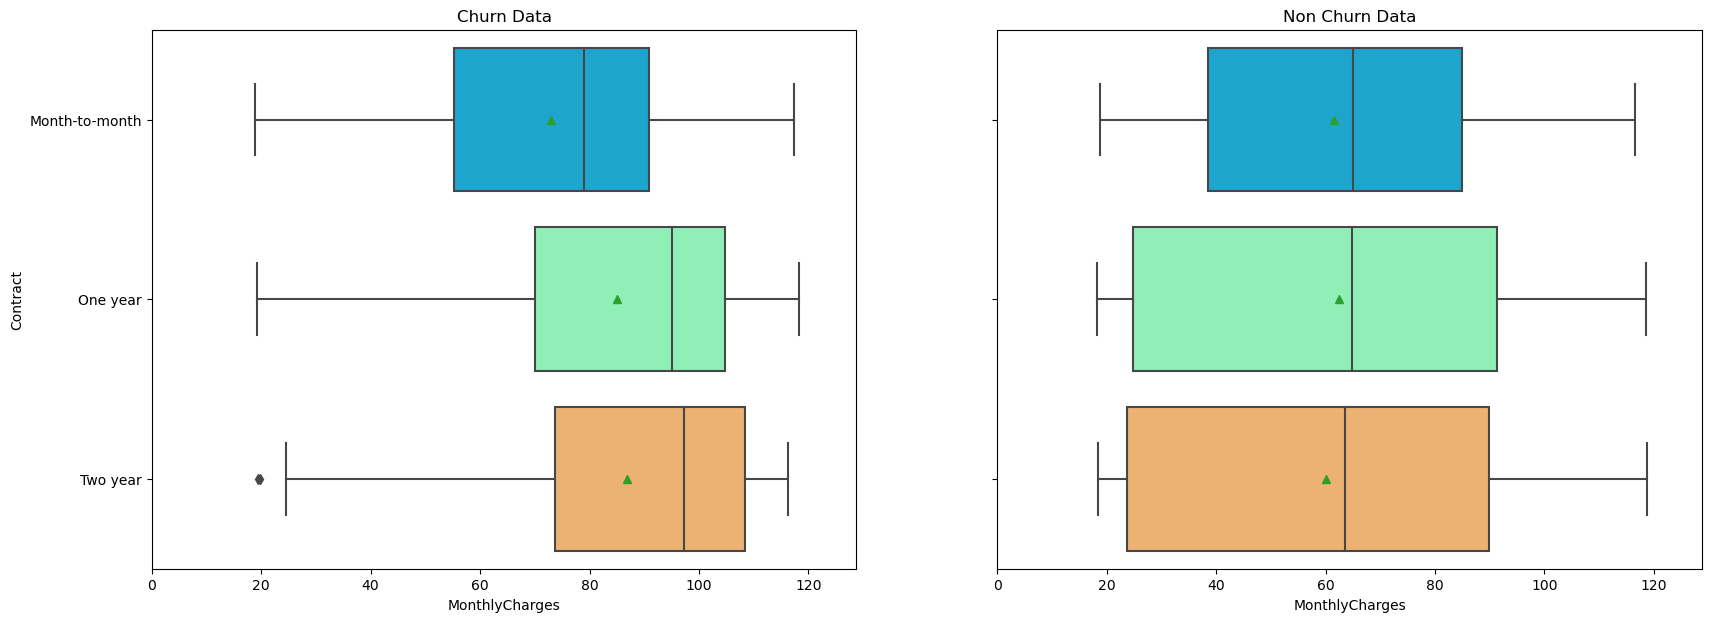

In [109]:
boxplot_compare('Churn', "Contract", "MonthlyCharges")    

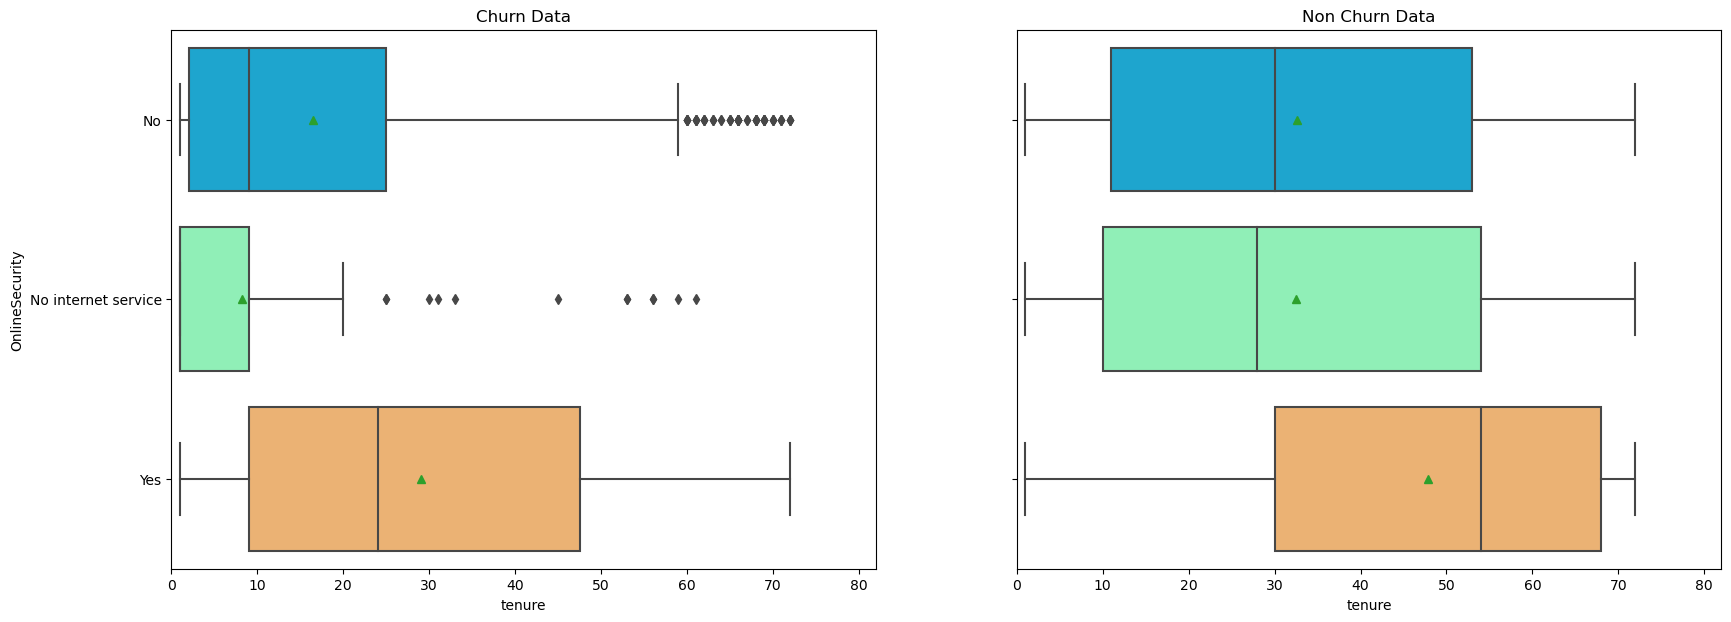

In [107]:
boxplot_compare('Churn', "OnlineSecurity", "tenure")    

### Categorial data

In [69]:
cat_cols = list(df.select_dtypes(include=['object']))
cat_cols.remove('customerID')
cat_cols.remove('Churn')
print(cat_cols)

['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


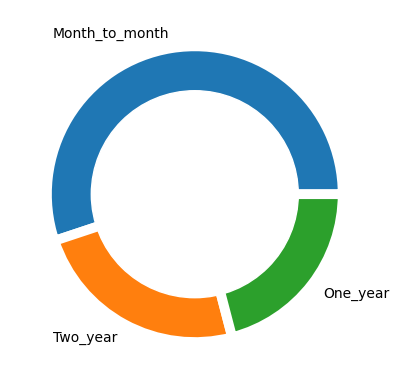

In [129]:
name = 'Contract'
c_loc = df.sort_values(by = name)
c_loc = c_loc.groupby([name])['Churn'].count()
c_loc = c_loc.reset_index()
c_loc['perc'] = c_loc['Churn']/df.shape[0] * 100
c_loc = c_loc.sort_values(by = 'perc', ascending = False)
c_loc['cum_perc'] = c_loc['perc'].cumsum()
c_loc = c_loc.reset_index(drop=True)

my_circle = plt.Circle( (0,0), 0.7, color='white')

plt.pie(c_loc.perc, labels=c_loc[name], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.


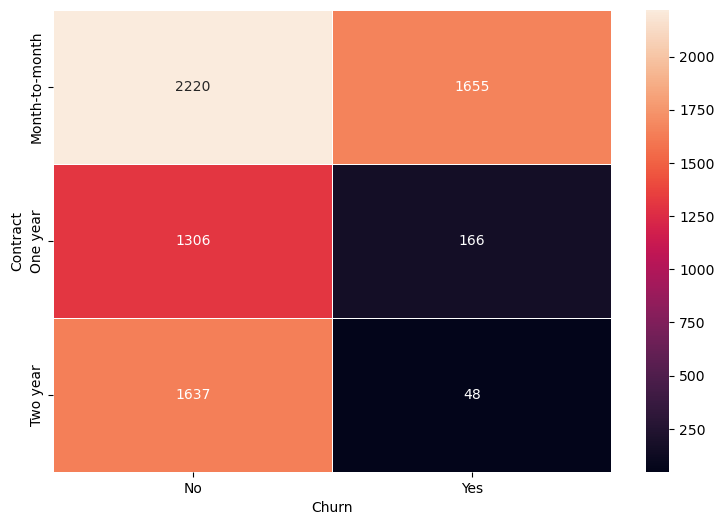

In [60]:
data_a = df.groupby(['Contract','Churn']).size()
data_a = data_a.reset_index()
data_a.columns = ['Contract','Churn','Count']
data_a = data_a.pivot('Contract','Churn','Count')

for i in range(data_a.shape[1]):
    data_a.iloc[:,i] = data_a.iloc[:,i].fillna(0)
    data_a.iloc[:,i] = data_a.iloc[:,i].astype(int)

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(data_a, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.show();

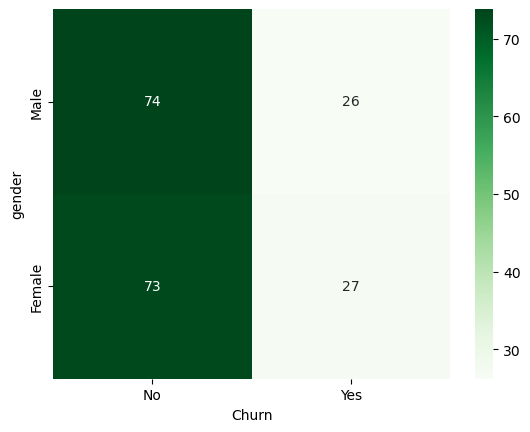

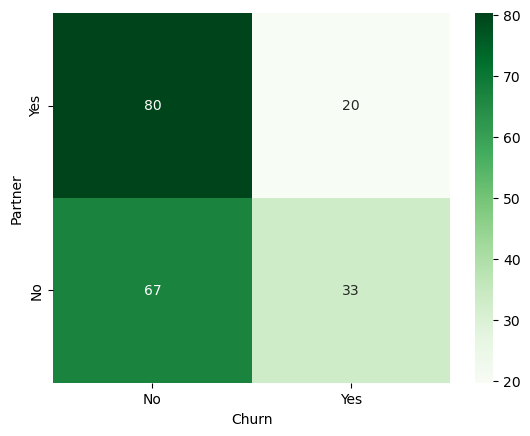

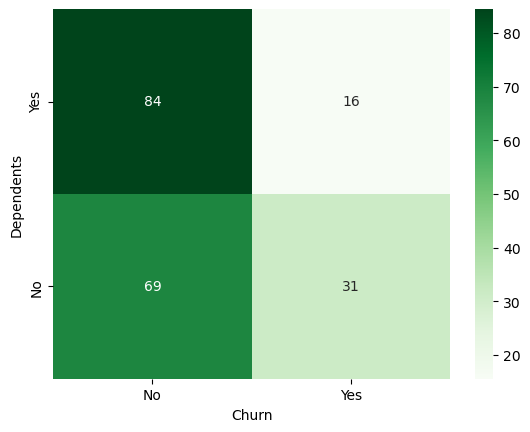

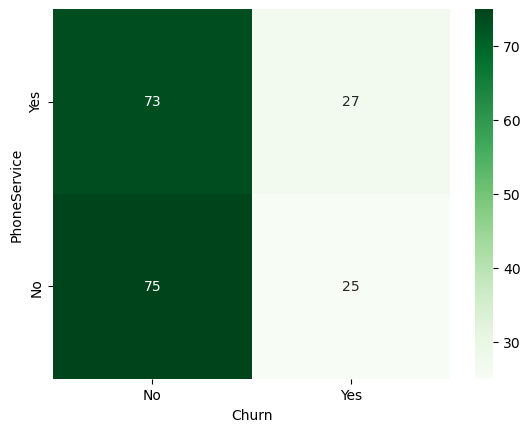

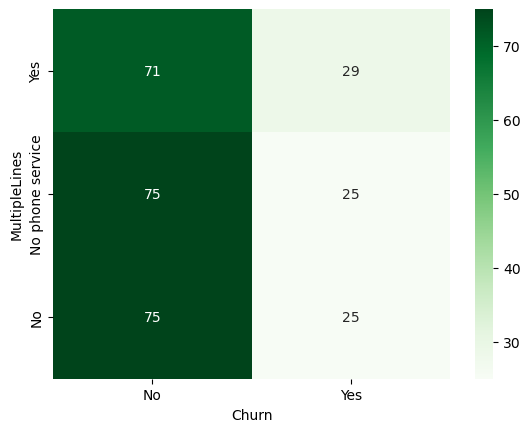

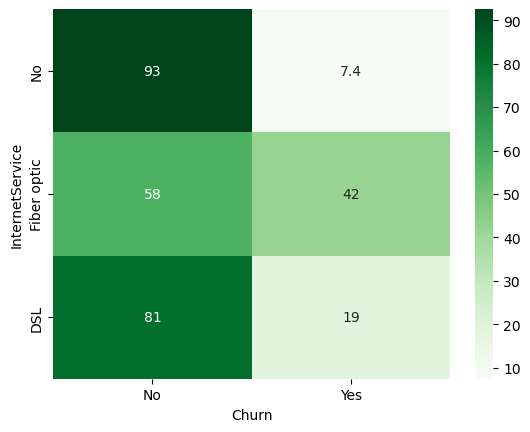

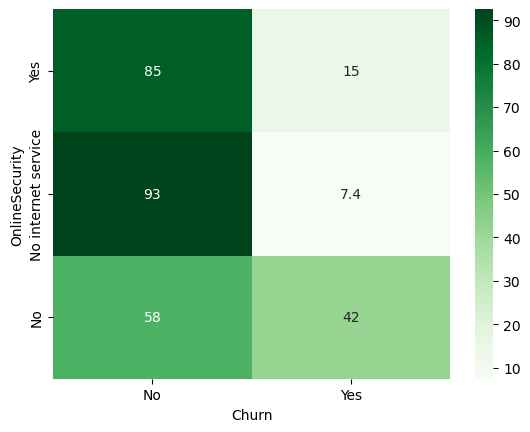

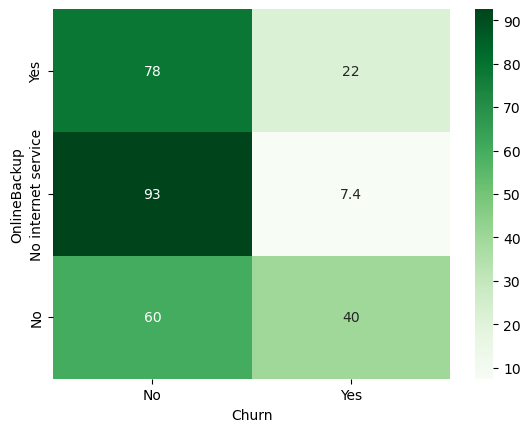

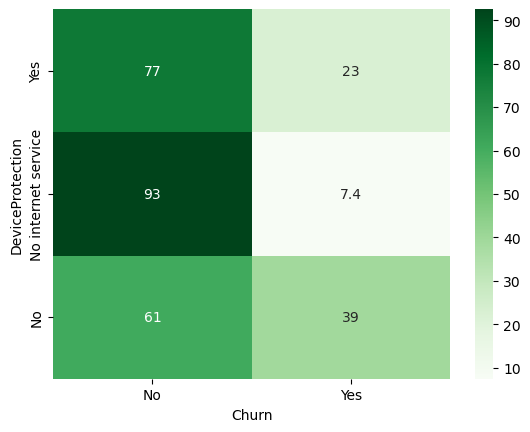

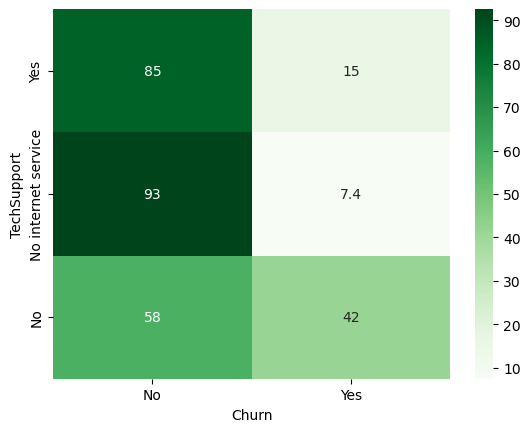

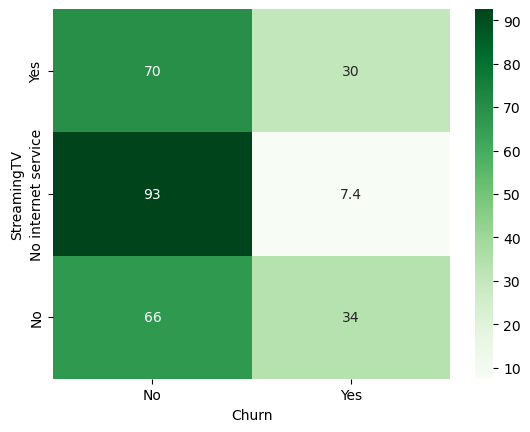

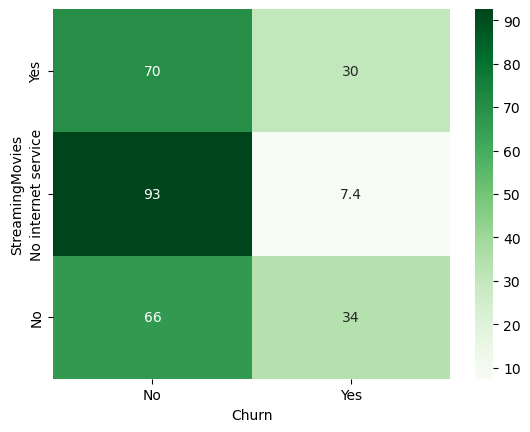

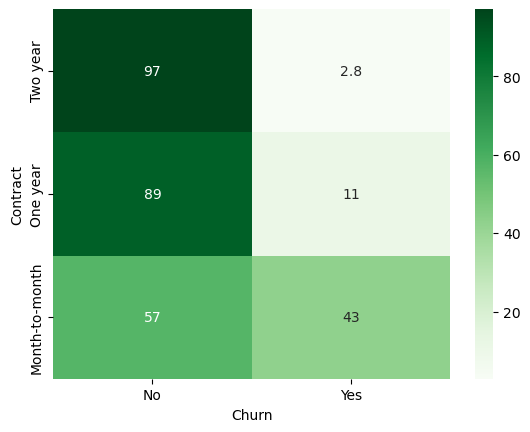

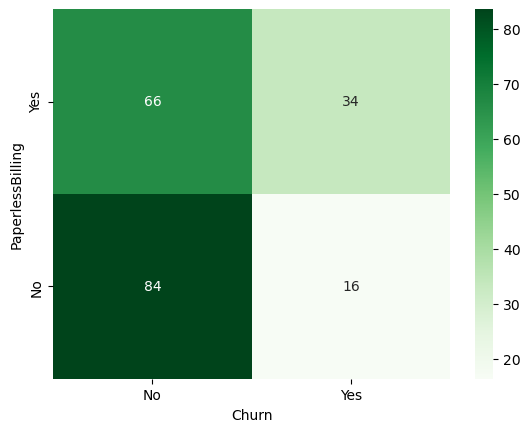

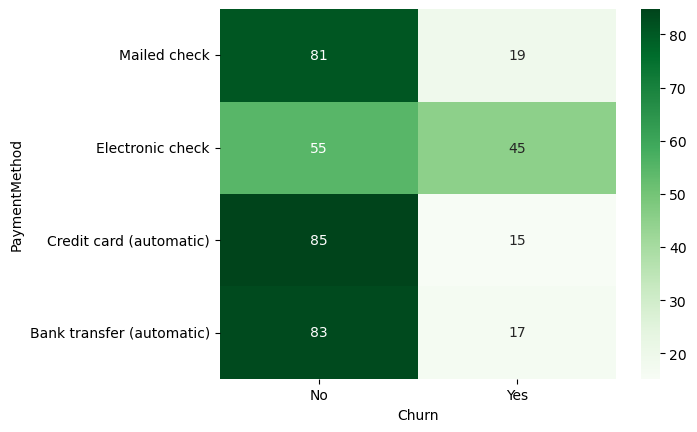

In [70]:
for name in cat_cols:
    cross_tab = pd.DataFrame(pd.crosstab(df[name], df.Churn, normalize='index'))
    cross_tab = cross_tab * 100

    ax = sns.heatmap(cross_tab, annot = True, cmap="Greens")
    ax.invert_yaxis()
    plt.show();

### Test/Train split

In [130]:
conv_cols = [col for col in df.columns if '_n' in col]
drop_cols = [re.sub('_n', "", x) for x in conv_cols]
drop_cols.remove('SeniorCitizen')
print(drop_cols)

['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn', 'gender']


In [131]:
print(list(df.columns))

['customerID', 'gender', 'SeniorCitizen_n', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Partner_n', 'Dependents_n', 'PhoneService_n', 'PaperlessBilling_n', 'Churn_n', 'gender_n']


In [132]:
#pd.crosstab(df.gender_n, columns = 'Count')

In [223]:
y = df.Churn_n
X = df.drop(['Churn_n','customerID'] + drop_cols, axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.4,
                                                    stratify = y,
                                                    random_state = 222)

print(X_train.shape, X_test.shape)
# (4219, 20) (2813, 20)

print('Churn rate train (%): ', round(y_train[y_train == 1].shape[0]/y_train.shape[0]*100,2))
print('Churn rate test (%): ', round(y_test[y_test == 1].shape[0]/y_test.shape[0]*100,2))

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

X_train_orig = X_train.copy()

(4219, 19) (2813, 19)
Churn rate train (%):  26.57
Churn rate test (%):  26.59


### Examine the features

In [87]:
y = y_train.copy()
X = X_train.copy()

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
    
discrete_features = X.dtypes == int

In [88]:
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

Contract              0.096910
tenure                0.083345
OnlineSecurity        0.063449
TechSupport           0.061518
InternetService       0.052963
MonthlyCharges        0.049854
PaymentMethod         0.048688
OnlineBackup          0.046357
DeviceProtection      0.041245
TotalCharges          0.039808
StreamingTV           0.030800
StreamingMovies       0.030745
PaperlessBilling_n    0.020531
Dependents_n          0.014876
Partner_n             0.011873
SeniorCitizen_n       0.010443
MultipleLines         0.000562
PhoneService_n        0.000062
gender_n              0.000000
Name: MI Scores, dtype: float64

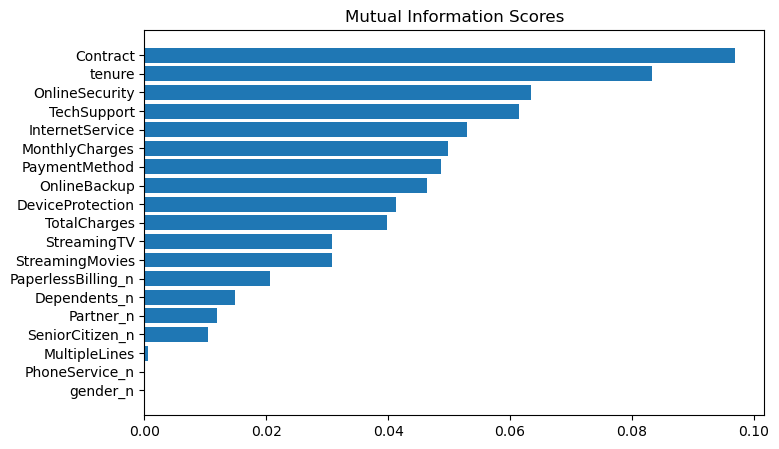

In [89]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)
plt.show();

### Features from tree classification

In [92]:
cat_cols = list(X_train.select_dtypes(include=['object']))
print(cat_cols)

ohe = OneHotEncoder()
ohe.fit(X_train[cat_cols])
colnames = ohe.get_feature_names_out(cat_cols)

cat_data_check = ohe_dset(X_train, cat_cols) 
print(cat_data_check.shape)

['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
(4219, 31)
(4219, 31)


In [93]:
num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
print(num_cols)

['SeniorCitizen_n', 'tenure', 'MonthlyCharges', 'TotalCharges', 'gender_n', 'Partner_n', 'Dependents_n', 'PhoneService_n', 'PaperlessBilling_n']


In [94]:
X = pd.concat([X_train[num_cols], cat_data_check], axis = 1)
y = y_train

clf = DecisionTreeClassifier(max_depth=5, random_state=1234)
model = clf.fit(X, y)

In [97]:
text_representation = tree.export_text(clf, feature_names=list(X.columns))

In [100]:
rule_lst = []
flattened_lst = []
flattened_lsts = []

for split_size in tqdm([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]):
    X_trees, X_tree_test, y_trees, y_tree_test = train_test_split(X,
                                                                  y,
                                                                  test_size = split_size,
                                                                  stratify = y,
                                                                  random_state = 222)
    print(X_trees.shape, y_trees.shape)
    
    model = clf.fit(X_trees, y_trees)
    text_representation = tree.export_text(clf, feature_names=list(X_trees.columns))
    rules, proba = get_rules(clf, list(X_trees.columns), [0,1], 80, 200)
    rule_lst.append(list(set(rules)))
    flattened_lst = [val for sublist in rule_lst for val in sublist]
    flattened_lst = list(set(flattened_lst))

for i in range(len(flattened_lst)):
    flattened_lsts.append(flattened_lst[i].split(' then class')[0])
flattened_lsts = list(set(flattened_lsts))

In [134]:
#flattened_lsts

### New features

In [135]:
for i, dset in enumerate([X_train, X_test]):

    dseta = dset.copy()
    dseta['feature_1'] = 0
    dseta.loc[(dseta.Contract != 'Month_to_month') &
              (dseta.MonthlyCharges <= 93.775) & 
              (dseta.OnlineSecurity != 'No') & 
              (dseta.MonthlyCharges > 65.4), 'feature_1'] = 1

    dseta['feature_2'] = 0
    dseta.loc[(dseta.Contract != 'Month_to_month') &
              (dseta.OnlineSecurity != 'No') & 
              (dseta.MonthlyCharges <= 65.275) & 
              (dseta.TotalCharges > 31.525), 'feature_2'] = 1

    dseta['feature_3'] = 0
    dseta.loc[(dseta.Contract != 'Month_to_month') & 
              (dseta.MonthlyCharges > 93.775) & 
              (dseta.tenure > 70.5) & 
              (dseta.TotalCharges <= 8678.625) & 
              (dseta.OnlineSecurity == 'Yes'), 'feature_3'] = 1

    dseta['feature_4'] = 0
    dseta.loc[(dseta.Contract != 'Month_to_month') & 
              (dseta.MonthlyCharges <= 93.775) & 
              (dseta.OnlineSecurity == 'No') & 
              (dseta.MonthlyCharges > 35.1) & 
              (dseta.tenure <= 46.5), 'feature_4'] = 1    
    
    dseta['feature_5'] = 0
    dseta.loc[(dseta.Contract != 'Month_to_month') & 
              (dseta.tenure <= 70.5) &
              (dseta.MonthlyCharges > 110.2), 'feature_5'] = 1    
    
    dseta['feature_6'] = 0
    dseta.loc[(dseta.Contract != 'Month_to_month') & 
              (dseta.MonthlyCharges > 93.95) &
              (dseta.tenure <= 70.5) & 
              (dseta.MonthlyCharges <= 103.2), 'feature_6'] = 1    
    
    dseta['feature_7'] = 0
    dseta.loc[(dseta.Contract != 'Month_to_month') & 
              (dseta.MonthlyCharges <= 93.775) &
              (dseta.OnlineSecurity == 'No') & 
              (dseta.MonthlyCharges > 35.1) & 
              (dseta.tenure > 46.5), 'feature_7'] = 1        
    
    dseta['feature_8'] = 0
    dseta.loc[(dseta.Contract == 'Month_to_month') &
              (dseta.InternetService == 'Fiber optic') & 
              (dseta.tenure <= 10.5) & 
              (dseta.TotalCharges <= 95.725) & 
              (dseta.PaymentMethod != 'Credit card (automatic)'), 'feature_8'] = 1
    
    dseta['feature_9'] = 0
    dseta.loc[(dseta.Contract == 'Month_to_month') & 
              (dseta.InternetService != 'Fiber optic') & 
              (dseta.tenure > 17.5) & 
              (dseta.PhoneService_n == 1), 'feature_9'] = 1    
    
    if i == 0:
        X_train = dseta
    elif i == 1:
        X_test = dseta

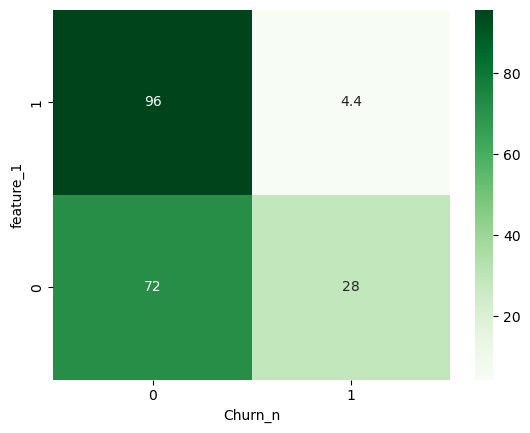

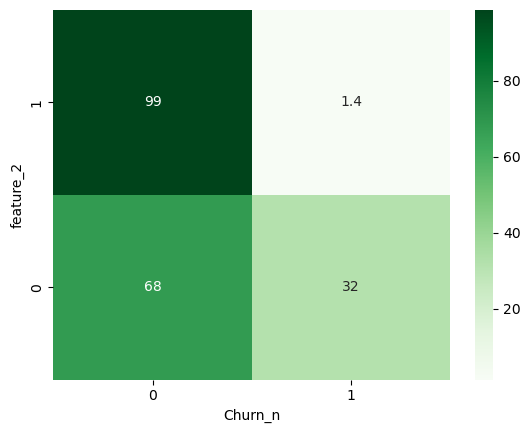

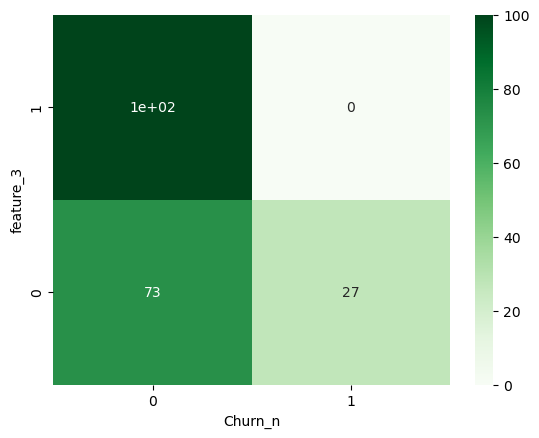

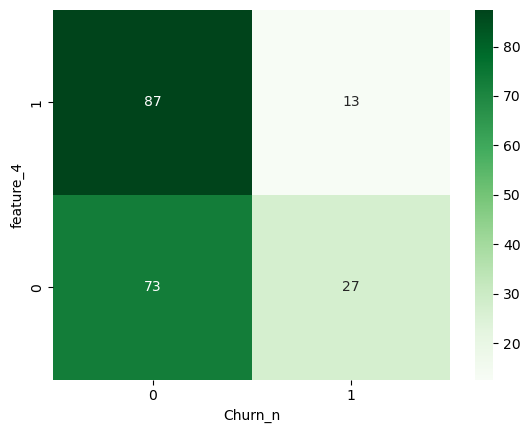

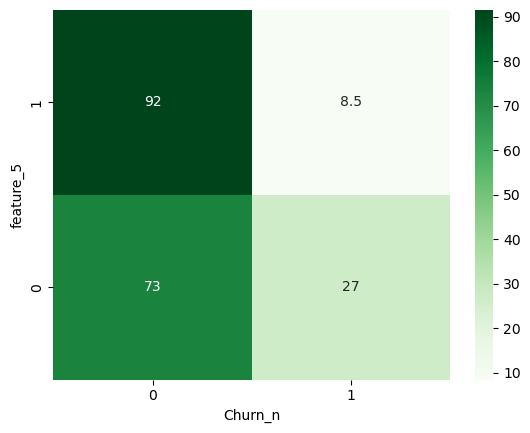

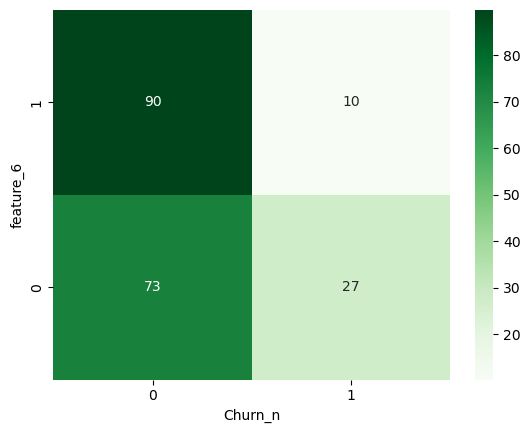

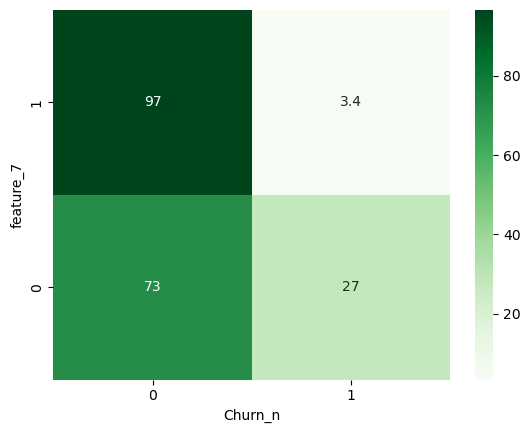

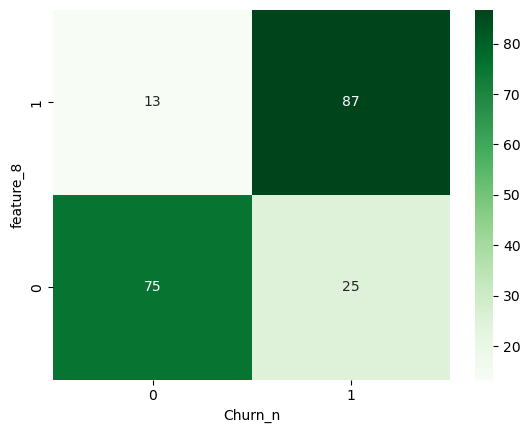

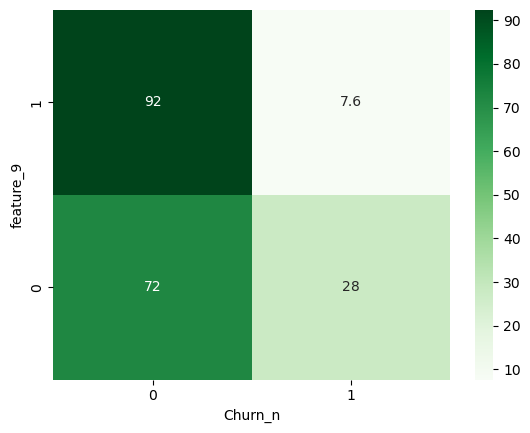

In [114]:
for name in [col for col in X_train.columns if 'feature_' in col]:
    cross_tab = pd.DataFrame(pd.crosstab(X_train[name], y_train, normalize='index'))
    cross_tab = cross_tab * 100

    ax = sns.heatmap(cross_tab, annot = True, cmap="Greens")
    ax.invert_yaxis()
    plt.show();

### Binning data

In [136]:
m_val_lst = ['MonthlyCharges','tenure']

for m_val in m_val_lst:
    X_train[m_val + '_bin'], bin_edges  = pd.qcut(X_train[m_val],
                                                   q = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],
                                                   retbins = True,
                                                   duplicates = 'drop')
    print(m_val, bin_edges,range(len(bin_edges)-1))

    X_train[m_val + '_bin']  = pd.cut(X_train[m_val],
                                       bins = bin_edges,
                                       labels = range(len(bin_edges)-1),
                                       duplicates = 'drop',
                                       include_lowest=True)
    X_train[m_val + '_bin']  = X_train[m_val + '_bin'].astype(str)
    X_train.loc[X_train[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'

    ### Test data ###
    X_test[m_val + '_bin'] = pd.cut(X_test[m_val],
                                    bins = bin_edges,
                                    labels = range(len(bin_edges)-1),
                                    include_lowest=True)
    
    X_test[m_val + '_bin'] = X_test[m_val + '_bin'].astype('str')
    X_test.loc[X_test[m_val + '_bin'] == 'nan',m_val + '_bin'] = 'Missing'
    


MonthlyCharges [ 18.25  20.05  25.23  48.64  59.56  70.6   79.2   85.53  94.2  101.81
 118.75] range(0, 10)
tenure [ 1.  2.  6. 12. 19. 28. 39. 50. 60. 69. 72.] range(0, 10)


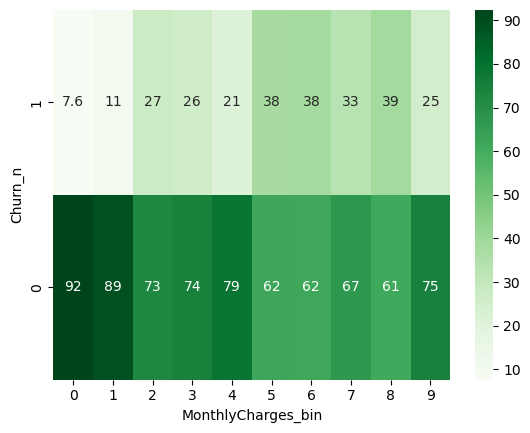

In [117]:
pd.crosstab(X_train[m_val + '_bin'], columns = 'Count')

re_data = pd.concat([X_train,y_train], axis = 1)

room_t = pd.DataFrame(pd.crosstab(re_data['Churn_n'], re_data['MonthlyCharges_bin'], normalize='columns'))
room_t = room_t * 100

ax = sns.heatmap(room_t, annot = True, cmap="Greens")
ax.invert_yaxis()

### Preprocess the model data

In [137]:
a = list(X_train.columns)
a.sort()
print(a)

X_train = X_train.drop(['tenure', 'MonthlyCharges'], axis = 1)
X_test = X_test.drop(['tenure', 'MonthlyCharges'], axis = 1)

['Contract', 'Dependents_n', 'DeviceProtection', 'InternetService', 'MonthlyCharges', 'MonthlyCharges_bin', 'MultipleLines', 'OnlineBackup', 'OnlineSecurity', 'PaperlessBilling_n', 'Partner_n', 'PaymentMethod', 'PhoneService_n', 'SeniorCitizen_n', 'StreamingMovies', 'StreamingTV', 'TechSupport', 'TotalCharges', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'gender_n', 'tenure', 'tenure_bin']


In [138]:
#########################################
### Check for single non varying data ###
#########################################

lst = []
for name in list(X_train.columns):
    if (X_train[name].nunique() == 1):
        lst.append(name)

print(lst)

['feature_8']


In [140]:
#pd.crosstab(X_train.feature_8, columns = 'Count')

col_0      Count
feature_8       
0           4219

In [142]:
try:
    X_train = X_train.drop(lst, axis = 1)
    X_test = X_test.drop(lst, axis = 1)
except:
    X_train = X_train
    X_test = X_test

In [143]:
#########################
### Multicollinearity ###
#########################

num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

vif = calculate_vif(X_train[num_cols])

a = vif[(vif.VIF > 10)]
to_drop_vif = list(a.Features)
print(to_drop_vif)
vif.sort_values(['VIF'], ascending = False)

[]


Features       VIF
1         TotalCharges  4.595076
4       PhoneService_n  4.424082
2            Partner_n  2.810831
5   PaperlessBilling_n  2.430599
3         Dependents_n  1.935720
6             gender_n  1.901992
14           feature_9  1.856030
7            feature_1  1.687847
8            feature_2  1.538929
9            feature_3  1.438596
12           feature_6  1.366746
0      SeniorCitizen_n  1.323641
13           feature_7  1.260013
11           feature_5  1.230968
10           feature_4  1.074934

In [146]:
num_cols = list(X_train.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if '_n' in col])))
num_cols = (list(set(num_cols) - set([col for col in X_train.columns if 'feature_' in col])))
print(num_cols)

['TotalCharges']


[]


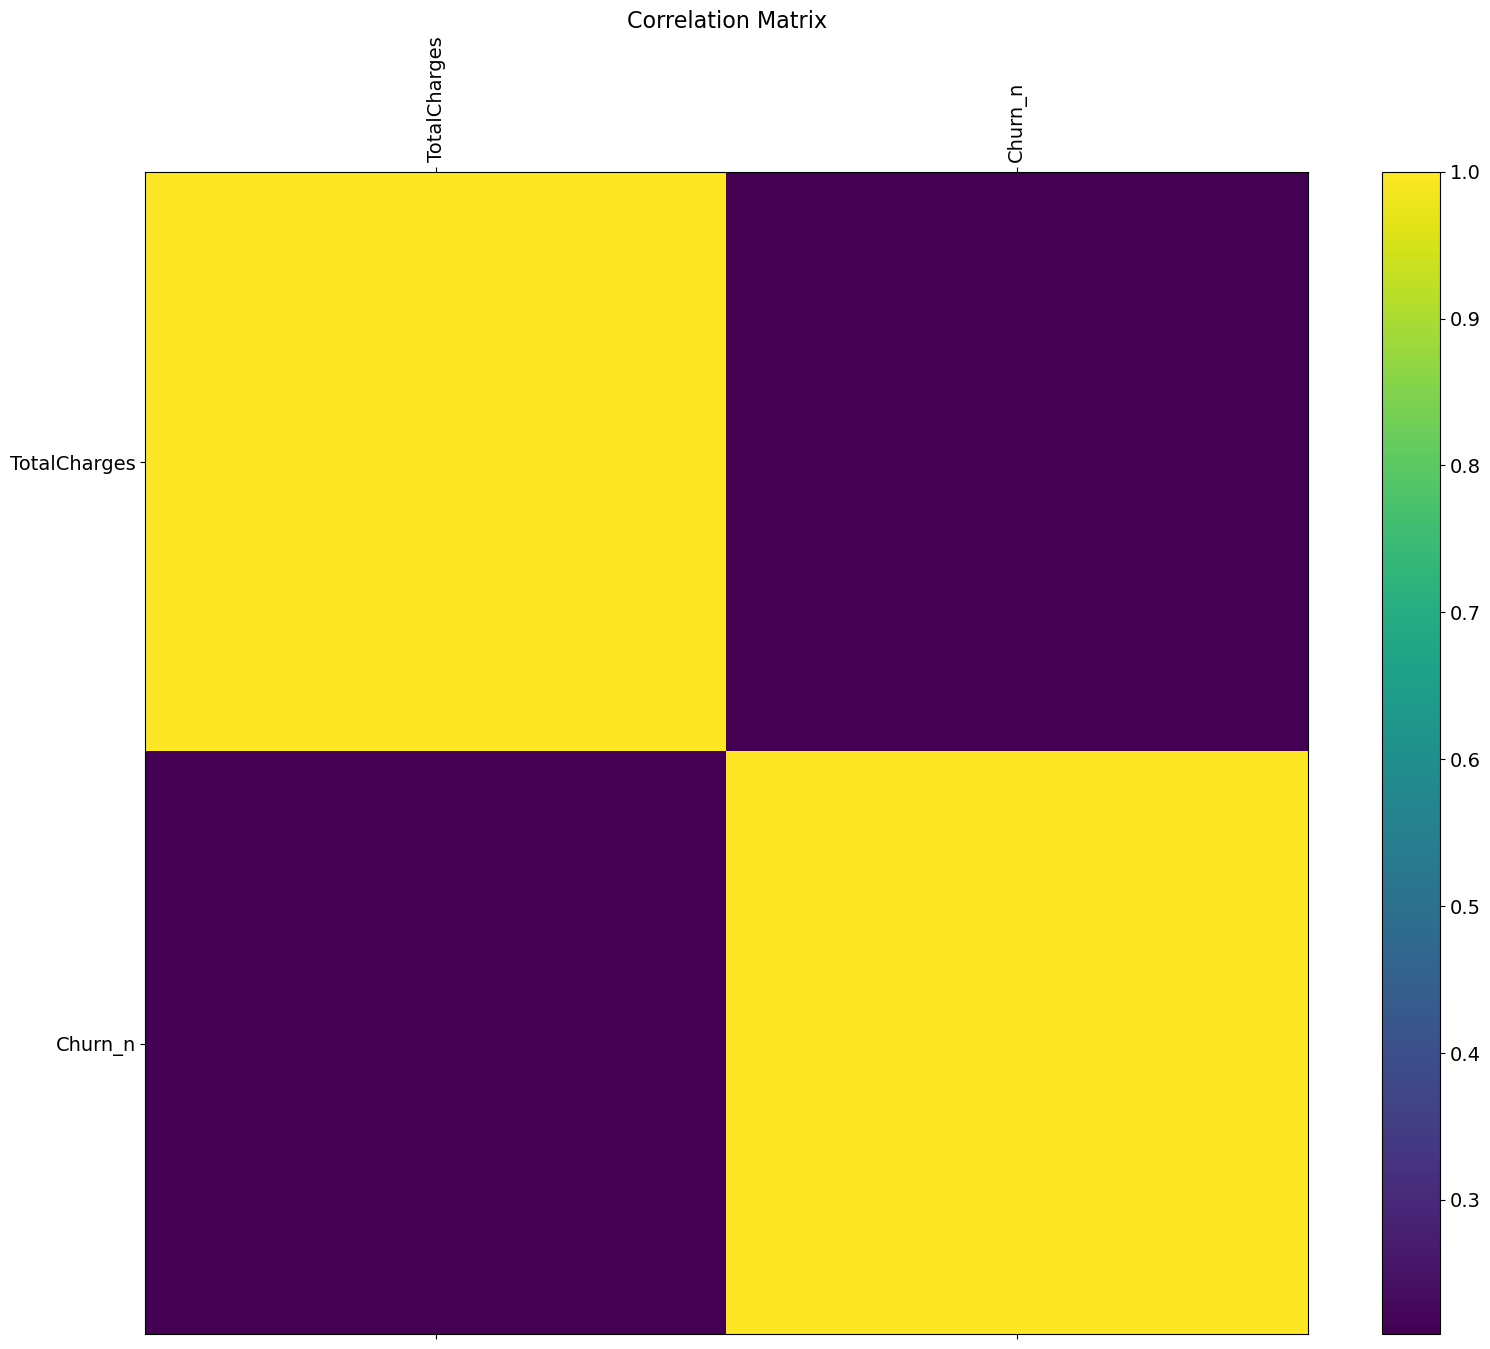

In [147]:
###################
### Correlation ###
###################

corre_data = pd.concat([X_train[num_cols],
                        pd.DataFrame(y_train)],
                       axis = 1)

cor_matrix = corre_data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

f = plt.figure(figsize=(19, 15))
plt.matshow(cor_matrix, fignum=f.number)
plt.xticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(corre_data.select_dtypes(['number']).shape[1]),
           corre_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show();

In [148]:
#####################
### MinMax scaler ###
#####################

print(X_train[num_cols].shape)

transformer_train = MinMaxScaler().fit(X_train[num_cols])
num_data_train = pd.DataFrame(transformer_train.transform(X_train[num_cols]))
num_data_train.columns = num_cols
print(num_data_train.shape)

num_data_test = minmax_dset(X_test,num_cols) ### Test ###

print(
    f'Data min:max {num_data_train.min().min(),num_data_train.max().max()}')

(4219, 1)
(4219, 1)
(2813, 1)
Data min:max (0.0, 0.9999999999999999)


In [151]:
cat_cols = list(X_train.select_dtypes(include=['object']))
cat_cols = (list(set(cat_cols) - set([col for col in X_train.columns if '_bin' in col])))

In [149]:
################################### 
### High cardinality adjustment ###
################################### 

card_vars = []
cat_data = X_train[cat_cols]
for i in range(cat_data.shape[1]):
    X_train.loc[X_train[cat_data.columns[i]].isnull(),cat_data.columns[i]] = 'Missing'
    X_test.loc[X_test[cat_data.columns[i]].isnull(),cat_data.columns[i]] = 'Missing'

    if (cat_data.iloc[:,i].nunique() > 60):
        print(cat_data.columns[i],len(list(set(cat_data.iloc[:,i]))))

        a = pd.crosstab(cat_data[cat_data.columns[i]],columns='Count')
        a = pd.DataFrame(a).sort_values('Count',ascending=False).reset_index()
        val_list = list(a.iloc[:20,0])
        X_train.loc[~X_train[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'
        X_test.loc[~X_test[cat_data.columns[i]].isin(val_list),cat_data.columns[i]] = 'Other'

    if (len(list(set(cat_data.iloc[:,i]))) > 100):
        card_vars.append(cat_data.columns[i])

print(card_vars)

StreamingMovies 3
OnlineBackup 3
DeviceProtection 3
TechSupport 3
StreamingTV 3
MultipleLines 3
OnlineSecurity 3
PaymentMethod 4
Contract 3
InternetService 3
[]


In [153]:
########################
### One hot encoding ###
########################

ohe = OneHotEncoder()
print(X_train.shape)
# (357127, 56)

### Train ###

ohe.fit(X_train[cat_cols])
colnames = ohe.get_feature_names_out(cat_cols)

cat_data_train = ohe_dset(X_train,cat_cols)  ### Train ###

for name in list(cat_data_train.columns):
    cat_data_train[name] = cat_data_train[name].astype(int)

cat_data_test = ohe_dset(X_test,cat_cols)    ### Test ###

print(cat_data_train.shape)
cat_data_train.head()

print(
    f'Data min:max {cat_data_train.min().min(),cat_data_train.max().max()}')

(4219, 27)
(4219, 31)
(2813, 31)
(4219, 31)
Data min:max (0, 1)


In [168]:
print([col for col in X_train.columns if '_bin' in col])
#pd.crosstab(X_train['tenure_bin'], columns = 'Count')

['MonthlyCharges_bin', 'tenure_bin']


In [159]:
ordinal_encoder_bin = OrdinalEncoder(categories=[['Missing','0','1','2','3','4','5','6','7','8','9']])
ordinal_encoder_bin.fit(pd.DataFrame(X_train['MonthlyCharges_bin']))
ord_data_train = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_train['MonthlyCharges_bin'])),columns = ['MonthlyCharges_bin'])
ord_data_test = pd.DataFrame(ordinal_encoder_bin.transform(pd.DataFrame(X_test['MonthlyCharges_bin'])), columns = ['MonthlyCharges_bin'])

ordinal_encoder_bin.fit(pd.DataFrame(X_train['tenure_bin']))
ord_data_train['tenure_bin'] = ordinal_encoder_bin.transform(pd.DataFrame(X_train['tenure_bin']))
ord_data_test['tenure_bin'] = ordinal_encoder_bin.transform(pd.DataFrame(X_test['tenure_bin']))

for name in ['MonthlyCharges_bin','tenure_bin']:
    ord_data_train[name] = ord_data_train[name].astype(int)

transformer_train_o = MinMaxScaler().fit(ord_data_train)
ord_data_train = pd.DataFrame(transformer_train_o.transform(ord_data_train))
ord_data_train.columns = ['MonthlyCharges_bin','tenure_bin']

print(
    f'Training data min:max {ord_data_train.min().min(),ord_data_train.max().max()}')

for name in ['MonthlyCharges_bin','tenure_bin']:
    ord_data_test[name] = ord_data_test[name].astype(int)

transformer_test_o = MinMaxScaler().fit(ord_data_test)
ord_data_test = pd.DataFrame(transformer_test_o.transform(ord_data_test))
ord_data_test.columns = ['MonthlyCharges_bin','tenure_bin']

print(
    f'Test data min:max {ord_data_test.min().min(),ord_data_test.max().max()}')

Training data min:max (0.0, 1.0)
Test data min:max (0.0, 1.0)


In [164]:
print([col for col in X_train.columns if '_n' in col])
print([col for col in X_train.columns if 'feature_' in col])
bin_data_train = X_train[[col for col in X_train.columns if '_n' in col] + [col for col in X_train.columns if 'feature_' in col]]
bin_data_test = X_test[[col for col in X_train.columns if '_n' in col] + [col for col in X_train.columns if 'feature_' in col]]

['SeniorCitizen_n', 'Partner_n', 'Dependents_n', 'PhoneService_n', 'PaperlessBilling_n', 'gender_n']
['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_9']


In [176]:
cat_data_train = cat_data_train[(list(set(list(cat_data_train.columns)) - set(['level_0', 'index'])))]
num_data_train = num_data_train[(list(set(list(num_data_train.columns)) - set(['level_0', 'index'])))]
ord_data_train = ord_data_train[(list(set(list(ord_data_train.columns)) - set(['level_0', 'index'])))]
bin_data_train = bin_data_train[(list(set(list(bin_data_train.columns)) - set(['level_0', 'index'])))]

cat_data_test = cat_data_test[(list(set(list(cat_data_test.columns)) - set(['level_0', 'index'])))]
num_data_test = num_data_test[(list(set(list(num_data_test.columns)) - set(['level_0', 'index'])))]
ord_data_test = ord_data_test[(list(set(list(ord_data_test.columns)) - set(['level_0', 'index'])))]
bin_data_test = bin_data_test[(list(set(list(bin_data_test.columns)) - set(['level_0', 'index'])))]

In [177]:
print("Categorical data", list(cat_data_train.columns))
print("Numerical data", list(num_data_train.columns))
print("Ordinal data", list(ord_data_train.columns))
print("Binned data", list(bin_data_train.columns))

Categorical data ['TechSupport_Yes', 'OnlineSecurity_No', 'InternetService_No', 'OnlineBackup_No_internet_service', 'Contract_One_year', 'PaymentMethod_Electronic_check', 'OnlineBackup_Yes', 'Contract_Month_to_month', 'OnlineSecurity_Yes', 'DeviceProtection_Yes', 'OnlineSecurity_No_internet_service', 'DeviceProtection_No_internet_service', 'DeviceProtection_No', 'StreamingTV_No_internet_service', 'MultipleLines_Yes', 'StreamingMovies_Yes', 'MultipleLines_No phone service', 'Contract_Two_year', 'PaymentMethod_Mailed_check', 'StreamingMovies_No', 'InternetService_Fiber_optic', 'MultipleLines_No', 'InternetService_DSL', 'TechSupport_No_internet_service', 'OnlineBackup_No', 'StreamingTV_Yes', 'TechSupport_No', 'StreamingTV_No', 'StreamingMovies_No internet service', 'PaymentMethod_Bank_transfer_automatic', 'PaymentMethod_Credit_card_automatic']
Numerical data ['TotalCharges']
Ordinal data ['tenure_bin', 'MonthlyCharges_bin']
Binned data ['PaperlessBilling_n', 'Dependents_n', 'feature_2', '

In [178]:
###########################
### Bring data together ###
###########################

print(cat_data_train.shape, num_data_train.shape, ord_data_train.shape, bin_data_train.shape)
cat_data_train = cat_data_train.reset_index()
num_data_train = num_data_train.reset_index()
ord_data_train = ord_data_train.reset_index()
bin_data_train = bin_data_train.reset_index()

X_train_mod = pd.concat([cat_data_train,num_data_train],axis = 1)
X_train_mod = pd.concat([X_train_mod,ord_data_train],axis = 1)
X_train_mod = pd.concat([X_train_mod,bin_data_train],axis = 1)
print(X_train_mod.shape)

print(cat_data_test.shape, num_data_test.shape, bin_data_test.shape)
cat_data_test = cat_data_test.reset_index()
num_data_test = num_data_test.reset_index()
bin_data_test = bin_data_test.reset_index()
X_test_mod = pd.concat([cat_data_test,num_data_test],axis = 1)
X_test_mod = pd.concat([X_test_mod,ord_data_test],axis = 1)
X_test_mod = pd.concat([X_test_mod,bin_data_test],axis = 1)
print(X_test_mod.shape)

print(X_train_mod.shape, X_test_mod.shape)

(4219, 31) (4219, 1) (4219, 2) (4219, 14)
(4219, 52)
(2813, 31) (2813, 1) (2813, 14)
(2813, 51)
(4219, 52) (2813, 51)


In [179]:
####################################################
### Check that train/test sets have same columns ###
####################################################

try:
    X_train_cols = list(set(X_train_mod.columns))
    X_train_cols.remove('index')
    X_train_mod = X_train_mod[X_train_cols]

except:
    X_train_mod = X_train_mod
    
try:
    X_train_cols = list(set(X_train_mod.columns))
    X_train_cols.remove('level_0')
    X_train_mod = X_train_mod[X_train_cols]

except:
    X_train_mod = X_train_mod

mod_cols = (list(set(list(X_train_mod.columns)) - set(['index'])))
X_train_mod = X_train_mod[mod_cols]
miss_lst = list(set(list(X_train_mod.columns)) - set(list(X_test_mod.columns)))

for name in miss_lst:
    X_test_mod[name] = 0
X_test_mod = X_test_mod[list(X_train_mod.columns)]

drop_test_lst = list(set(list(X_test_mod.columns)) - set(list(X_train_mod.columns)))
X_test_mod = X_test_mod.drop(drop_test_lst, axis = 1)


print(X_train_mod.shape, X_test_mod.shape)
# (64215, 105) (42811, 135) (10148, 107)


(4219, 48) (2813, 48)


In [180]:
a = list(X_train_mod.columns)
a.sort()
print(a)

['Contract_Month_to_month', 'Contract_One_year', 'Contract_Two_year', 'Dependents_n', 'DeviceProtection_No', 'DeviceProtection_No_internet_service', 'DeviceProtection_Yes', 'InternetService_DSL', 'InternetService_Fiber_optic', 'InternetService_No', 'MonthlyCharges_bin', 'MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'OnlineBackup_No', 'OnlineBackup_No_internet_service', 'OnlineBackup_Yes', 'OnlineSecurity_No', 'OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes', 'PaperlessBilling_n', 'Partner_n', 'PaymentMethod_Bank_transfer_automatic', 'PaymentMethod_Credit_card_automatic', 'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check', 'PhoneService_n', 'SeniorCitizen_n', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'StreamingTV_No', 'StreamingTV_No_internet_service', 'StreamingTV_Yes', 'TechSupport_No', 'TechSupport_No_internet_service', 'TechSupport_Yes', 'TotalCharges', 'feature_1', 'feature_2', 'feature_3',

### Clustering

100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


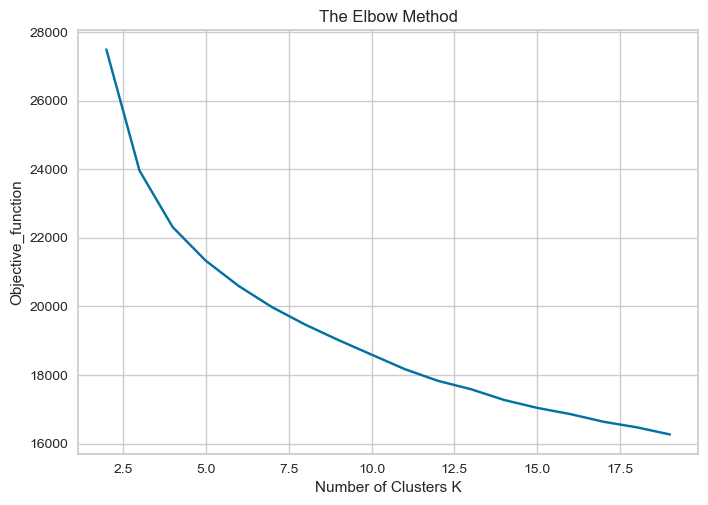

In [198]:
all_data = pd.concat([X_train_mod, y_train], axis = 1)

objective_function = []
for i in tqdm(range(2, 20)):
    clustering = KMeans(n_clusters=i, init='k-means++')
    clustering.fit(all_data)
    objective_function.append(clustering.inertia_)

plt.plot(range(2, 20), objective_function)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters K')
plt.ylabel('Objective_function')
plt.show()

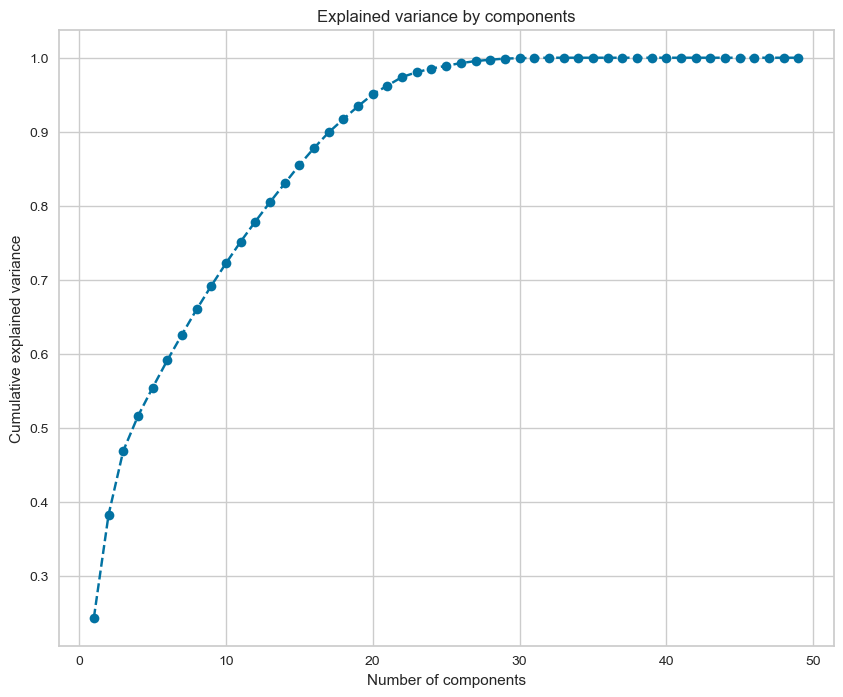

In [199]:
###########
### PCA ###
###########

pca = PCA()
pca.fit(all_data)

plt.figure(figsize=(10,8))
plt.plot(range(1,len(pca.explained_variance_ratio_.cumsum())+1), pca.explained_variance_ratio_.cumsum(),
         marker='o',linestyle='--')
plt.title("Explained variance by components")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show();

In [200]:
pca = PCA(n_components=13)
pca.fit(all_data)
scores_pca = pca.transform(all_data)

100%|██████████| 38/38 [00:16<00:00,  2.33it/s]


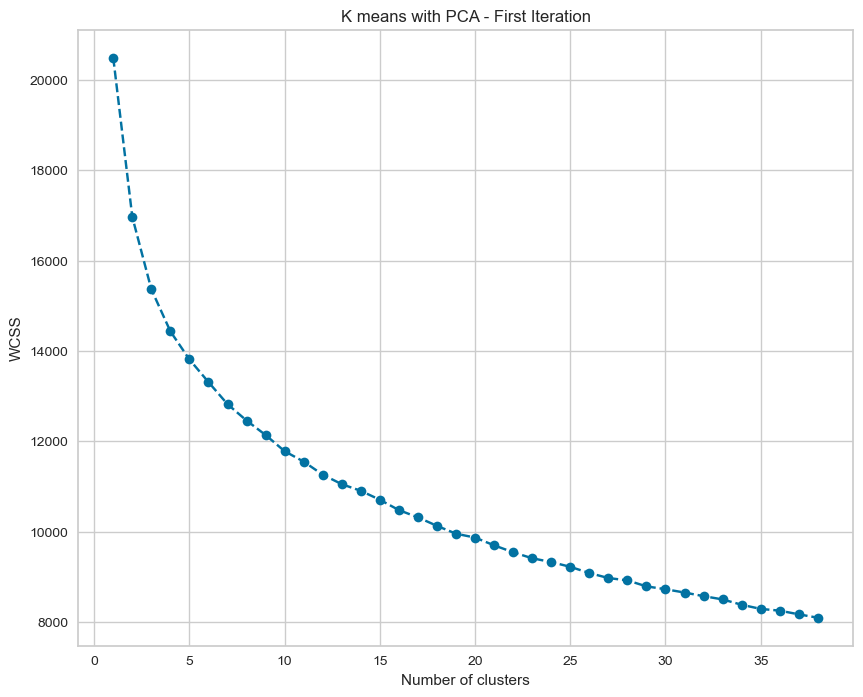

In [202]:
wcss = []
for i in tqdm(range(2,40)):
    kmeans_pca = KMeans(n_clusters = i, init = "k-means++", random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, len(wcss)+1), wcss,
         marker='o', linestyle='--')
plt.title("K means with PCA - First Iteration")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show();

In [203]:
tuned_clustering = KMeans(n_clusters=15, init='k-means++', random_state=0)
labels = tuned_clustering.fit_predict(all_data)

metrics.silhouette_score(
    all_data, tuned_clustering.labels_, metric='euclidean')

0.11928568091541258

In [210]:
kmeans_pca = KMeans(n_clusters=15, init="k-means++", random_state=42)
kmeans_pca.fit(scores_pca)
print(pd.DataFrame(scores_pca).shape)
df_segm_pca_means = pd.concat(
    [all_data.reset_index(drop=True), pd.DataFrame(scores_pca)],axis=1)

df_segm_pca_means.columns.values[-13:] = ['Component 1', 'Component 2','Component 3','Component 4','Component 5',
                                          'Component 6', 'Component 7','Component 8','Component 9','Component 10',
                                          'Component 11', 'Component 12','Component 13']
df_segm_pca_means['Clusters'] = kmeans_pca.labels_
plt.show()

(4219, 13)


In [222]:
#df_segm_pca_means.head()
#pd.DataFrame(scores_pca).head()
pd.crosstab(df_segm_pca_means.Clusters, columns = 'Count')
print(df_segm_pca_means.shape)

(4219, 63)


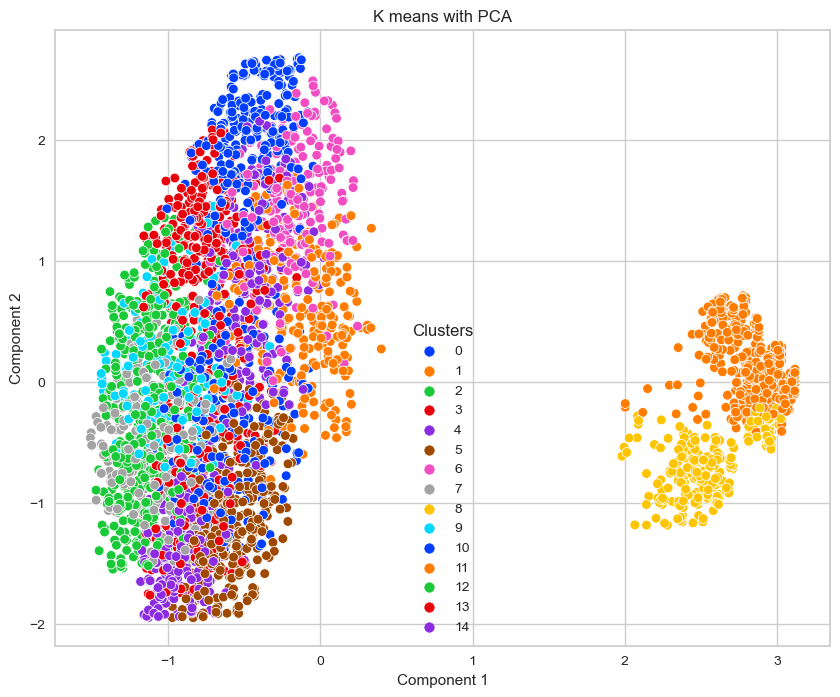

In [212]:
x_axis = df_segm_pca_means['Component 1']
y_axis = df_segm_pca_means['Component 2']
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue=df_segm_pca_means['Clusters'], palette="bright")
plt.title("K means with PCA")
plt.show();

In [213]:
num_cols = list(df.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in df.columns if '_n' in col])))
print(num_cols)

['tenure', 'TotalCharges', 'MonthlyCharges']


In [220]:
pd.crosstab(clus_data.Clusters.isna(), columns = 'Count')

col_0     Count
Clusters       
False      4219
True       2820

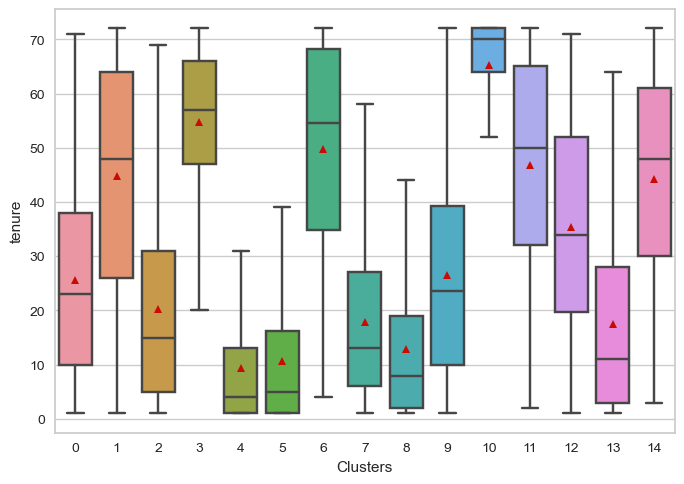

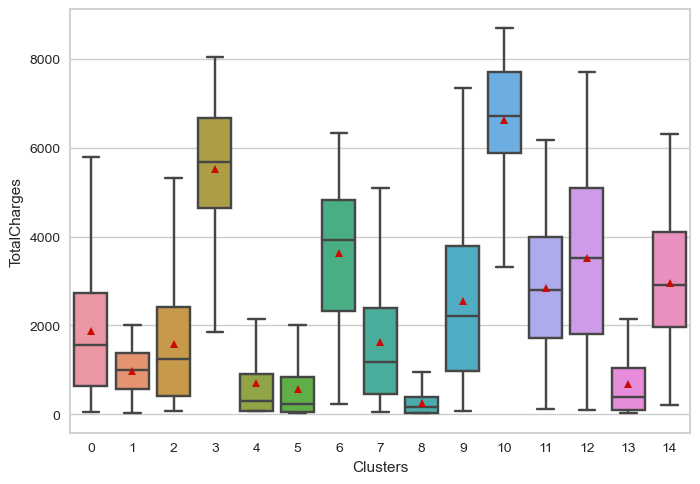

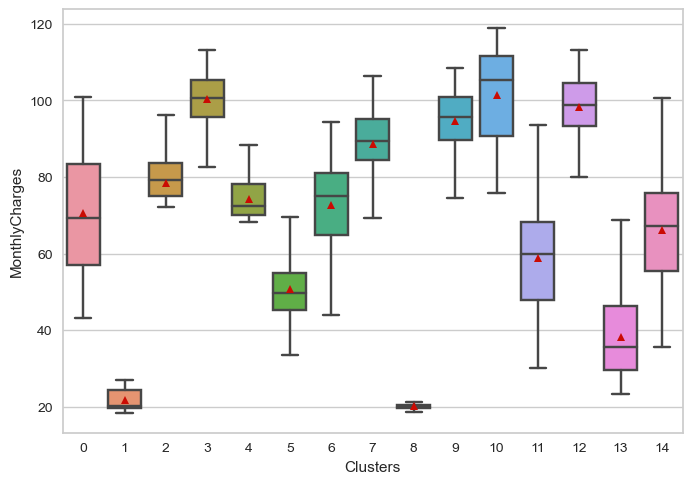

In [224]:
clus_data = pd.concat([df_segm_pca_means['Clusters'],X_train_orig], axis = 1)
clus_data['Clusters'] = clus_data['Clusters'].astype(int)

for name in num_cols:
    sns.boxplot(data=clus_data, x="Clusters", y=name, showmeans = True, showfliers = False)
    plt.xlabel("Clusters")
    plt.ylabel(name)
    plt.show()

In [225]:
cat_cols = list(clus_data.select_dtypes(include=['object']))
print(cat_cols)

['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [232]:
r = [0,1,2,3,4]
raw_data = {'greenBars': [20, 1.5, 7, 10, 5], 'orangeBars': [5, 15, 5, 10, 15],'blueBars': [2, 15, 18, 5, 10]}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['greenBars'], df['orangeBars'], df['blueBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]
blueBars = [i / j * 100 for i,j in zip(df['blueBars'], totals)]

print(totals)
print(greenBars)

[27.0, 31.5, 30.0, 25.0, 30.0]
[74.07407407407408, 4.761904761904762, 23.333333333333332, 40.0, 16.666666666666664]


In [249]:
target_t = pd.DataFrame(pd.crosstab(clus_data.Clusters, clus_data.MultipleLines, normalize='index'))
target_t = target_t * 100
target_t = pd.DataFrame(target_t)
target_t = target_t.reset_index()
target_t

MultipleLines  Clusters          No  No phone service         Yes
0                     0   66.532258          0.403226   33.064516
1                     1   65.120968          0.000000   34.879032
2                     2    0.000000          0.000000  100.000000
3                     3   27.147766          0.000000   72.852234
4                     4  100.000000          0.000000    0.000000
5                     5   87.500000          5.232558    7.267442
6                     6   42.857143         27.678571   29.464286
7                     7   44.890511          0.000000   55.109489
8                     8   94.694960          0.000000    5.305040
9                     9   39.705882          0.000000   60.294118
10                   10    7.382550          0.000000   92.617450
11                   11   40.248963         27.385892   32.365145
12                   12   15.079365          0.000000   84.920635
13                   13    2.293578         85.321101   12.385321
14                   14   30.046948         30.985915   38.967136

In [257]:
print(bars3)

[0.0, 0.0, 100.0]


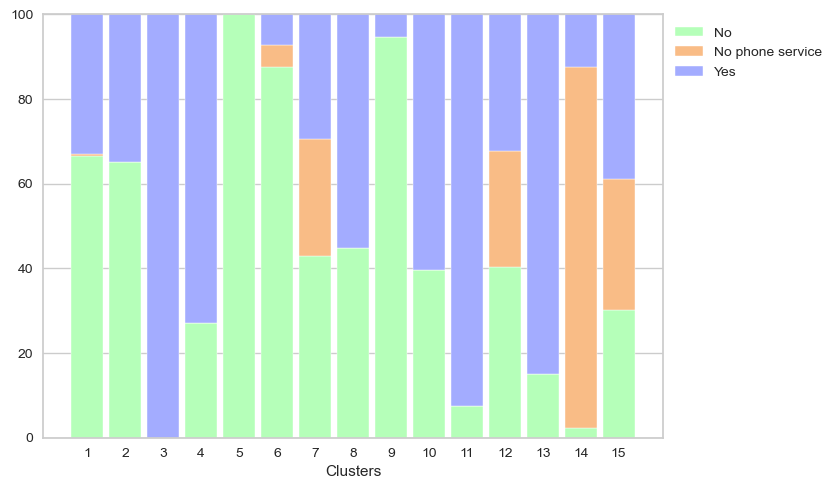

In [264]:
r = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
 
bars1 = list(target_t.iloc[:,1])
bars2 = list(target_t.iloc[:,2])
bars3 = list(target_t.iloc[:,3])

# plot
barWidth = 0.85
names = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15')
# Create green Bars
plt.bar(r, bars1, color='#b5ffb9', edgecolor='white', width=barWidth, label = 'No')
# Create orange Bars
plt.bar(r, bars2, bottom=bars1, color='#f9bc86', edgecolor='white', width=barWidth, label = 'No phone service')
# Create blue Bars
plt.bar(r, bars3, bottom=[i+j for i,j in zip(bars1, bars2)], color='#a3acff', edgecolor='white', width=barWidth, label = 'Yes')
 
# Custom x axis
plt.xticks(r, names)
plt.xlabel("Clusters")

plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
 
# Show graphic
plt.show()

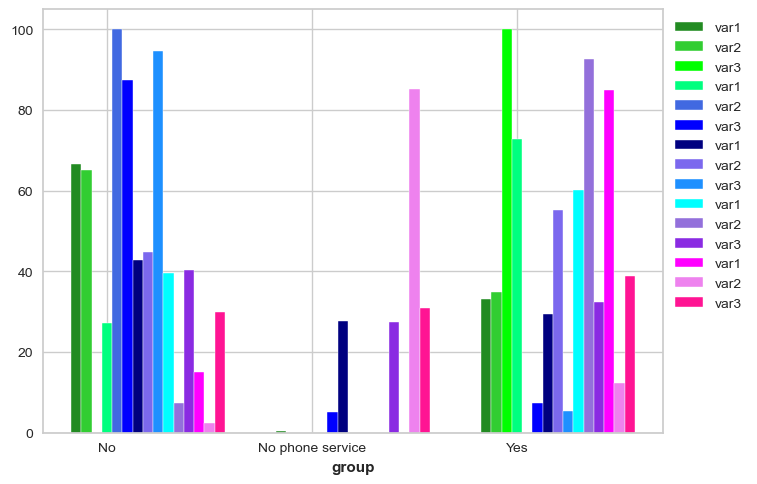

In [252]:
barWidth = 0.05
 
# set heights of bars
bars1 = list(target_t.iloc[0,1:])
bars2 = list(target_t.iloc[1,1:])
bars3 = list(target_t.iloc[2,1:])
bars4 = list(target_t.iloc[3,1:])
bars5 = list(target_t.iloc[4,1:])
bars6 = list(target_t.iloc[5,1:])
bars7 = list(target_t.iloc[6,1:])
bars8 = list(target_t.iloc[7,1:])
bars9 = list(target_t.iloc[8,1:])
bars10 = list(target_t.iloc[9,1:])
bars11 = list(target_t.iloc[10,1:])
bars12 = list(target_t.iloc[11,1:])
bars13 = list(target_t.iloc[12,1:])
bars14 = list(target_t.iloc[13,1:])
bars15 = list(target_t.iloc[14,1:])
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]
r9 = [x + barWidth for x in r8]
r10 = [x + barWidth for x in r9]
r11 = [x + barWidth for x in r10]
r12 = [x + barWidth for x in r11]
r13 = [x + barWidth for x in r12]
r14 = [x + barWidth for x in r13]
r15 = [x + barWidth for x in r14]
 
# Make the plot
plt.bar(r1, bars1, color='forestgreen', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='limegreen', width=barWidth, edgecolor='white', label='var2')
plt.bar(r3, bars3, color='lime', width=barWidth, edgecolor='white', label='var3')
plt.bar(r4, bars4, color='springgreen', width=barWidth, edgecolor='white', label='var1')
plt.bar(r5, bars5, color='royalblue', width=barWidth, edgecolor='white', label='var2')
plt.bar(r6, bars6, color='blue', width=barWidth, edgecolor='white', label='var3')
plt.bar(r7, bars7, color='navy', width=barWidth, edgecolor='white', label='var1')
plt.bar(r8, bars8, color='mediumslateblue', width=barWidth, edgecolor='white', label='var2')
plt.bar(r9, bars9, color='dodgerblue', width=barWidth, edgecolor='white', label='var3')
plt.bar(r10, bars10, color='cyan', width=barWidth, edgecolor='white', label='var1')
plt.bar(r11, bars11, color='mediumpurple', width=barWidth, edgecolor='white', label='var2')
plt.bar(r12, bars12, color='blueviolet', width=barWidth, edgecolor='white', label='var3')
plt.bar(r13, bars13, color='magenta', width=barWidth, edgecolor='white', label='var1')
plt.bar(r14, bars14, color='violet', width=barWidth, edgecolor='white', label='var2')
plt.bar(r15, bars15, color='deeppink', width=barWidth, edgecolor='white', label='var3')

#https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
 
# Add xticks on the middle of the group bars
plt.xlabel('Cluster', fontweight='bold')
plt.xticks([r + barWidth + 0.1 for r in range(len(bars1))], ['No', 'No phone service', 'Yes'])
 
# Create legend & Show graphic
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Models

#### Baseline

In [181]:
########################################################
### Check the performance on all the baseline models ###
########################################################

models = select_model(X_train_mod, y_train)

`use_label_encoder` is deprecated in 1.7.0.
 80%|████████  | 8/10 [00:20<00:10,  5.49s/it]`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
100%|██████████| 10/10 [00:23<00:00,  2.32s/it]


In [182]:
models.head(20)

model run_time  accuracy
0      AdaBoostClassifier     0.03  0.842087
1         RidgeClassifier     0.01  0.840848
2      CatBoostClassifier     0.25  0.837379
3          LGBMClassifier     0.02  0.836811
4           SGDClassifier     0.01  0.836784
5           XGBClassifier     0.04  0.824235
6             BernoulliNB     0.01  0.821487
9  DecisionTreeClassifier     0.01  0.664949
7     ExtraTreeClassifier     0.01  0.661190
8         DummyClassifier      0.0  0.500000

#### Catboost

In [187]:
######################################
### CatBoost hyperparameter tuning ###
######################################

pbounds = {"n_estimators": (150,400),
           "depth": (2,7),
           "learning_rate": (0.01, 0.2),
           "subsample":(0.6, 1.0),
           "num_leaves": (16,40),
           "max_bin":(150,300),
           "l2_leaf_reg":(2,10),
           "model_size_reg": (0,10)
}
optimizer = BayesianOptimization(
    f = CB_opt,
    pbounds = pbounds,
    verbose = 2,
    random_state = 888,
)

optimizer.maximize(init_points = 15, n_iter = 25)

print(optimizer.max)


print("CV score: {:<8.5f}".format(CB_opt(int(optimizer.max['params']['n_estimators']),
                                         round(optimizer.max['params']['depth'],0),
                                         optimizer.max['params']['learning_rate'],
                                         round(optimizer.max['params']['max_bin'],0),
                                         optimizer.max['params']['subsample'],
                                         round(optimizer.max['params']['num_leaves'],0),
                                         optimizer.max['params']['l2_leaf_reg'],
                                         optimizer.max['params']['model_size_reg'])))

###########################
### Fit the tuned model ###
###########################

cboost_model_hy = CatBoostClassifier(depth = round(optimizer.max['params']['depth'],0),
                                    l2_leaf_reg = optimizer.max['params']['l2_leaf_reg'],
                                    learning_rate = optimizer.max['params']['learning_rate'],
                                    max_bin = round(optimizer.max['params']['max_bin'],0),
                                    n_estimators = int(optimizer.max['params']['n_estimators']),
                                    num_leaves = round(optimizer.max['params']['num_leaves'],0),
                                    subsample = optimizer.max['params']['subsample'],
                                    random_state = 88,
                                    grow_policy = "Lossguide",
                                    verbose = 0,
                                    eval_metric = "AUC")

|   iter    |  target   |   depth   | l2_lea... | learni... |  max_bin  | model_... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.716     | 6.298     | 3.317     | 0.1019    | 288.2     | 4.286     | 164.4     | 38.2      | 0.863     |
| 2         | 0.7137    | 2.665     | 6.268     | 0.1809    | 187.3     | 0.3017    | 168.1     | 36.98     | 0.8234    |
| 3         | 0.71      | 6.58      | 7.068     | 0.06382   | 204.8     | 0.9223    | 243.1     | 24.34     | 0.8821    |
| 4         | 0.7154    | 5.243     | 2.327     | 0.05023   | 150.2     | 1.39      | 203.0     | 16.63     | 0.7784    |
| 5         | 0.7162    | 3.196     | 9.636     | 0.1825    | 279.4     | 0.9159    | 394.4     | 25.88     | 0.7833    |
| 6         | 0.7169    | 4.63      | 4.355     | 0.1947    | 177.2     | 3.034     | 193.6     | 28.66     | 0.6083    |
| 7         | 0.7172    

CV score: 0.71331 


In [184]:
#################################
### LGBM Hyperparamter tuning ###
#################################

import lightgbm as lgb

%time

### prepare data ###

train_data = lgb.Dataset(data = X_train_mod,
                         label = y_train,
                         free_raw_data = False)

### parameters ###

lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                        'num_leaves': (24, 80),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'max_depth': (5, 30),
                                        'max_bin':(20,90),
                                        'min_data_in_leaf': (20, 80),
                                        'min_sum_hessian_in_leaf':(0,100),
                                        'subsample': (0.01, 1.0)},
                             random_state=200)


lgbBO.maximize(init_points = 15,
               n_iter = 25)

model_auc=[]
for model in range(len( lgbBO.res)):
    model_auc.append(lgbBO.res[model]['target'])

    # return best parameters
opt_params_lbgm = lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

opt_params_lbgm[1]["num_leaves"] = int(round(opt_params_lbgm[1]["num_leaves"]))
opt_params_lbgm[1]['max_depth'] = int(round(opt_params_lbgm[1]['max_depth']))
opt_params_lbgm[1]['min_data_in_leaf'] = int(round(opt_params_lbgm[1]['min_data_in_leaf']))
opt_params_lbgm[1]['max_bin'] = int(round(opt_params_lbgm[1]['max_bin']))
opt_params_lbgm[1]['objective']='binary'
opt_params_lbgm[1]['metric']='auc'
opt_params_lbgm[1]['is_unbalance']=True
opt_params_lbgm[1]['boost_from_average']=False
opt_params_lbgm = opt_params_lbgm[1]

print(opt_params_lbgm)

folds = StratifiedKFold(n_splits=10,
                        shuffle=True,
                        random_state=31416)
folds.get_n_splits(X_train_mod, y_train)

oof = np.zeros(len(X_train_mod))
predictions = np.zeros(len(X_test_mod))

for train_index, test_index in folds.split(X_train_mod, y_train):

    trainx, x_test_cv = X_train_mod.iloc[train_index], X_train_mod.iloc[test_index]
    trainy, y_test_cv = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[test_index]

    trn_data = lgb.Dataset(trainx,
                           label = trainy)
    val_data = lgb.Dataset(x_test_cv,
                           label = y_test_cv)

    num_round = 15000
    lbgm_model_hy = lgb.train(opt_params_lbgm,
                              trn_data,
                              num_round,
                              valid_sets = [trn_data, val_data],
                              verbose_eval = 500,
                              early_stopping_rounds = 250)

    oof[test_index] = lbgm_model_hy.predict(x_test_cv, num_iteration = lbgm_model_hy.best_iteration)

    predictions += lbgm_model_hy.predict(X_test_mod, num_iteration = lbgm_model_hy.best_iteration) / folds.n_splits
    pred_labels = np.rint(predictions)

print("CV score: {:<8.5f}".format(roc_auc_score(y_test,predictions)))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 8.11 µs
|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Warning] bagging_fraction is set=0.9895264513703341, subsample=0.4615201756036703 will be ignored. Current value: bagging_fraction=0.9895264513703341
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosin

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.9963605418316657, subsample=0.2580000042232922 will be ignored. Current value: bagging_fraction=0.9963605418316657
[LightGBM] [Warning] bagging_fraction is set=0.9963605418316657, subsample=0.2580000042232922 will be ignored. Current value: bagging_fraction=0.9963605418316657
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 47
[LightGBM] [Warning] bagging_fraction is set=0.9963605418316657, subsample=0.2580000042232922 will be ignored. Current value: bagging_fraction=0.9963605418316657
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

| 4         | 0.849     | 0.9281    | 0.5869    | 0.1144    | 87.62     | 23.97     | 60.78     | 32.93     | 25.48     | 0.8056    |
[LightGBM] [Warning] bagging_fraction is set=0.9280786928822388, subsample=0.805623782185316 will be ignored. Current value: bagging_fraction=0.9280786928822388
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.994565837939734
[LightGBM] [Warning] bagging_fraction is set=0.994565837939734, subsample=0.8559475937048635 will be ignored. Current value: bagging_fraction=0.9

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 105
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 48
[LightGBM] [Warning] bagging_fraction is set=0.9291117734024503, subsample=0.306134228089106 will be ignored. Current value: bagging_fraction=0.9291117734024503
[LightGBM] [Warning] bagging_fraction is set=0.9291117734024503, subsample=0.306134228089106 will be ignored. Current value: bagging_fraction=0.9291117734024503
[LightGBM] [Warning] bagging_fraction is set=0.9291117734024503, subsample=0.306134228089106 will be ignored. Current value: bagging_fraction=0.9291117734024503
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.9779671308949308, subsample=0.9169944578097257 will be ignored. Current value: bagging_fraction=0.9779671308949308
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 48
[LightGBM] [Warning] bagging_fraction is set=0.9779671308949308, subsample=0.9169944578097257 will be ignored. Current value: bagging_fraction=0.9779671308949308
[LightGBM] [Warning] bagging_fraction is set=0.9779671308949308, subsample=0.9169944578097257 will be ignored. Current value: bagging_fraction=0.9779671308949308
[LightGBM] [Warning] bagging_fraction is set=0.9779671308949308, subsample=0.91699445780972

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.8128832810269322, subsample=0.5478918834143229 will be ignored. Current value: bagging_fraction=0.8128832810269322
[LightGBM] [Warning] bagging_fraction is set=0.8128832810269322, subsample=0.5478918834143229 will be ignored. Current value: bagging_fraction=0.8128832810269322
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 47
[LightGBM] [Warning] bagging_fraction is set=0.8128832810269322, subsample=0.5478918834143229 will be ignored. Current value: bagging_fraction=0.8128832810269322
[LightGBM] [Warning] bagging_fraction is set=0.8128832810269322, subsample=0.5478918834143229 will be ignored. Current value: bagging_fraction=0.8128832810

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 47
[LightGBM] [Warning] bagging_fraction is set=0.9106504355221197, subsample=0.5333530050275148 will be ignored. Current value: bagging_fraction=0.9106504355221197
[LightGBM] [Warning] bagging_fraction is set=0.9106504355221197, subsample=0.5333530050275148 will be ignored. Current value: bagging_fraction=0.9106504355221197
[LightGBM] [Warning] bagging_fraction is set=0.9106504355221197, subsample=0.5333530050275148 will be ignored. Current value: bagging_fraction=0.9106504355221197
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.8777828046899155, subsample=0.9577740093257218 will be ignored. Current value: bagging_fraction=0.8777828046899155
[LightGBM] [Warning] bagging_fraction is set=0.8777828046899155, subsample=0.9577740093257218 will be ignored. Current value: bagging_fraction=0.8777828046899155
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 48
[LightGBM] [Warning] bagging_fraction is set=0.8777828046899155, subsample=0.9577740093257218 will be ignored. Current value: bagging_fraction=0.8777828046899155
[LightGBM] [Warning] bagging_fraction is set=0.8777828046899155, subsample=0.95777400932572

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265736 -> initscore=-1.016365
[LightGBM] [Info] Start training from score -1.016365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265736 -> initscore=-1.016365
[LightGBM] [Info] Start training from score -1.016365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265736 -> initscore=-1.016365
[LightGBM] [Info] Start training from score -1.016365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265736 -> initscore=-1.016365
[LightGBM] [Info] Start training from score -1.016365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265473 -> initscore=-1.017715
[LightGBM] [Info] Start training from score -1.017715
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.8226424867916587, subsample=0.41448205776510916 will be ignored. Current value: bagging_fraction=0.8226424867916587
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 135
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 47
[LightGBM] [Warning] bagging_fraction is set=0.8226424867916587, subsample=0.41448205776510916 will be ignored. Current value: bagging_fraction=0.8226424867916587
[LightGBM] [Warning] bagging_fraction is set=0.8226424867916587, subsample=0.41448205776510916 will be ignored. Current value: bagging_fraction=0.8226424867916587
[LightGBM] [Warning] bagging_fraction is set=0.8226424867916587, subsample=0.41448205776

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.8000632537506381, subsample=0.45311031900349197 will be ignored. Current value: bagging_fraction=0.8000632537506381
[LightGBM] [Warning] bagging_fraction is set=0.8000632537506381, subsample=0.45311031900349197 will be ignored. Current value: bagging_fraction=0.8000632537506381
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 48
[LightGBM] [Warning] bagging_fraction is set=0.8000632537506381, subsample=0.45311031900349197 will be ignored. Current value: bagging_fraction=0.8000632537506381
[LightGBM] [Warning] bagging_fraction is set=0.8000632537506381, subsample=0.45311031900

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8000632537506381, subsample=0.45311031900349197 will be ignored. Current value: bagging_fraction=0.8000632537506381
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.01 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.9297188437554942, subsample=0.821431963710523 will be ignored. Current value: bagging_fraction=0.9297188437554942
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.9297188437554942, subsample=0.821431963710523 will be ignored. Current value: bagging_fraction=0.9297188437554942
[LightGBM] [Warning] bagging_fraction is set=0.9297188437554942, subsample=0.821431963710523 will be ignored. Current value: bagging_fraction=0.9297188437554942
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 47
[LightGBM] [Wa

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.9297188437554942, subsample=0.821431963710523 will be ignored. Current value: bagging_fraction=0.9297188437554942
[LightGBM] [Warning] bagging_fraction is set=0.933933176368286, subsample=0.19924477595861284 will be ignored. Current value: bagging_fraction=0.933933176368286
[LightGBM] [Warning] bagging_fraction is set=0.9297188437554942, subsample=0.821431963710523 will be ignored. Current value: bagging_fraction=0.9297188437554942
[LightGBM] [Warning] bagging_fraction is set=0.933933176368286, subsample=0.19924477595861284 will be ignored. Current value: bagging_fraction=0.933933176368286
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.9047103773911489, subsample=0.02110152297967699 will be ignored. Current value: bagging_fraction=0.9047103773911489
[LightGBM] [Info] Number of positive: 1008, number of negative: 2789
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 108
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 48
[LightGBM] [Warning] bagging_fraction is set=0.9047103773911489, subsample=0.02110152297967699 will be ignored. Current value: bagging_fraction=0.9047103773911489
[LightGBM] [Warning] bagging_fraction is set=0.9047103773911489, subsample=0.02110152297967699 will be ignored. Current value: bagging_fraction=0.9047103773911489
[LightGBM] [Warning] bagging_fraction is set=0.9047103773911489, subsample=0.02110152297

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.8312080501420223, subsample=0.956664633700172 will be ignored. Current value: bagging_fraction=0.8312080501420223
[LightGBM] [Warning] bagging_fraction is set=0.8312080501420223, subsample=0.956664633700172 will be ignored. Current value: bagging_fraction=0.8312080501420223
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 47
[LightGBM] [Warning] bagging_fraction is set=0.8312080501420223, subsample=0.956664633700172 will be ignored. Current value: bagging_fraction=0.8312080501420223
[LightGBM] [Warning] bagging_fraction is set=0.8312080501420223, subsample=0.956664633700172 w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
| 21        | 0.8485    | 0.8312    | 0.3828    | 0.5201    | 51.19     | 12.33     | 77.66     | 90

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.9785026641283072, subsample=0.9515936045869495 will be ignored. Current value: bagging_fraction=0.9785026641283072
[LightGBM] [Warning] bagging_fraction is set=0.9785026641283072, subsample=0.9515936045869495 will be ignored. Current value: bagging_fraction=0.9785026641283072
[LightGBM] [Warning] bagging_fraction is set=0.9785026641283072, subsample=0.9515936045869495 will be ignored. Current value: bagging_fraction=0.9785026641283072
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 47
[LightGBM] [Warning] bagging_fraction is set=0.9785026641283072, subsample=0.95159360458694

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 47
[LightGBM] [Warning] bagging_fraction is set=0.963460262993768, subsample=0.8261606321667111 will be ignored. Current value: bagging_fraction=0.963460262993768
[LightGBM] [Warning] bagging_fraction is set=0.963460262993768, subsample=0.8261606321667111 will be ignored. Current value: bagging_fraction=0.963460262993768
[LightGBM] [Warning] bagging_fraction is set=0.963460262993768, subsample=0.8261606321667111 will be ignored. Current value: bagging_fraction=0.963460262993768
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_col_wise=true` to remove the overhe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.963460262993768, subsample=0.8261606321667111 will be ignored. Current value: bagging_fraction=0.963460262993768
[LightGBM] [Warning] bagging_fraction is set=0.8809679823107908, subsample=0.1158382425989148 will be ignored. Current value: bagging_fraction=0.8809679823107908
[LightGBM] [Warning] bagging_fraction is set=0.8809679823107908, subsample=0.1158382425989148 will be ignored. Current value: bagging_fraction=0.8809679823107908
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8809679823107908, subsample=0.1158382425989148 will be ignored. Current value: bagging_fraction=0.8809679823107908
[LightGBM] [Warning] bagging_fraction is set=0.8809679823107908, subsample=0.1158382425989148 will be ignored. Current value: bagging_fraction=0.8809679823107908
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8809679823107908, subsample=0.1158382425989148 will be ignored. Current value: bagging_fraction=0.8809679823107908
[LightGBM] [Warning] bagging_fraction is set=0.9382786017461794, subsample=0.38062066751229023 will be ignored. Current value: bagging_fraction=0.9382786017461794
[LightGBM] [Warning] bagging_fraction is set=0.9382786017461794, subsample=0.38062066751229023 will be ignored. Current value: bagging_fraction=0.9382786017461794
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.9382786017461794, subsample=0.38062066751229023 will be ignored. Current value: bagging_fraction=0.9382786017461794
[LightGBM] [Warning] bagging_fraction is set=0.9382786017461794, subsample=0.38062066751229023 will be ignored. Current value: bagging_fraction=0.9382786017461794
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing ro

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

| 25        | 0.8493    | 0.9383    | 0.3213    | 0.1043    | 55.51     | 14.88     | 78.43     | 88.9      | 53.01     | 0.3806    |
[LightGBM] [Warning] bagging_fraction is set=0.9382786017461794, subsample=0.38062066751229023 will be ignored. Current value: bagging_fraction=0.9382786017461794
[LightGBM] [Warning] bagging_fraction is set=0.9653873590031019, subsample=0.19381026892879777 will be ignored. Current value: bagging_fraction=0.9653873590031019
[LightGBM] [Warning] bagging_fraction is set=0.9653873590031019, subsample=0.19381026892879777 will be ignored. Current value: bagging_fraction=0.9653873590031019
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.9653873590031019, subsample=0.19381026892879777 will be ignored. Current value: bagging_fraction=0.9653873590031019
[LightGBM] [Warning] bagging_fraction is set=0.9653873590031019, subsample=0.19381026892879777 will be ignored. Current value: bagging

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.9653873590031019, subsample=0.19381026892879777 will be ignored. Current value: bagging_fraction=0.9653873590031019
[LightGBM] [Warning] bagging_fraction is set=0.8583391108980054, subsample=0.34656386762969826 will be ignored. Current value: bagging_fraction=0.8583391108980054
[LightGBM] [Warning] bagging_fraction is set=0.8583391108980054, subsample=0.34656386762969826 will be ignored. Current value: bagging_fraction=0.8583391108980054
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8583391108980054, subsample=0.34656386762969826 will be ignored. Current value: bagging_fraction=0.8583391108980054
[LightGBM] [Warning] bagging_fraction is set=0.8583391108980054, subsample=0.34656386762969826 will be ignored. Current value: bagging_fraction=0.8583391108980054
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8583391108980054, subsample=0.34656386762969826 will be ignored. Current value: bagging_fraction=0.8583391108980054
[LightGBM] [Warning] bagging_fraction is set=0.940016168470718, subsample=0.7492699629301592 will be ignored. Current value: bagging_fraction=0.940016168470718
[LightGBM] [Warning] bagging_fraction is set=0.940016168470718, subsample=0.7492699629301592 will be ignored. Current value: bagging_fraction=0.940016168470718
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.940016168470718, subsample=0.7492699629301592 will be ignored. Current value: bagging_fraction=0.940016168470718
[LightGBM] [Warning] bagging_fraction is set=0.940016168470718, subsample=0.7492699629301592 will be ignored. Current value: bagging_fraction=0.940016168470718
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise mult

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.940016168470718, subsample=0.7492699629301592 will be ignored. Current value: bagging_fraction=0.940016168470718
[LightGBM] [Warning] bagging_fraction is set=0.9268611529159522, subsample=0.0982672133670917 will be ignored. Current value: bagging_fraction=0.9268611529159522
[LightGBM] [Warning] bagging_fraction is set=0.9268611529159522, subsample=0.0982672133670917 will be ignored. Current value: bagging_fraction=0.9268611529159522
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.9268611529159522, subsample=0.0982672133670917 will be ignored. Current value: bagging_fraction=0.9268611529159522
[LightGBM] [Warning] bagging_fraction is set=0.9268611529159522, subsample=0.0982672133670917 will be ignored. Current value: bagging_fraction=0.9268611529159522
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.9268611529159522, subsample=0.0982672133670917 will be ignored. Current value: bagging_fraction=0.9268611529159522
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.8329866519563027, subsample=0.165894781996791 will be ignored. Current value: bagging_fraction=0.8329866519563027
[LightGBM] [Warning] bagging_fraction is set=0.909454568116135, subsample=0.6247833545104878 will be ignored. Current value: bagging_fraction=0.909454568116135
[LightGBM] [Warning] bagging_fraction is set=0.909454568116135, subsample=0.6247833545104878 will be ignored. Current value: bagging_fraction=0.909454568116135
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.909454568116135, subsample=0.6247833545104878 will be ignored. Current value: bagging_fraction=0.909454568116135
[LightGBM] [Warning] bagging_fraction is set=0.909454568116135, subsample=0.6247833545104878 will be ignored. Current value: bagging_fraction=0.909454568116135
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 47
[LightGBM] [Warning] bagging_fraction is set=0.9280404773307145, subsample=0.029942376874776667 will be ignored. Current value: bagging_fraction=0.9280404773307145
[LightGBM] [Warning] bagging_fraction is set=0.9280404773307145, subsample=0.029942376874776667 will be ignored. Current value: bagging_fraction=0.9280404773307145
[LightGBM] [Warning] bagging_fraction is set=0.9280404773307145, subsample=0.029942376874776667 will be ignored. Current value: bagging_fraction=0.9280404773307145
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.9395237981600998, subsample=0.04191527436759694 will be ignored. Current value: bagging_fraction=0.9395237981600998
[LightGBM] [Warning] bagging_fraction is set=0.9395237981600998, subsample=0.04191527436759694 will be ignored. Current value: bagging_fraction=0.9395237981600998
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 47
[LightGBM] [Warning] bagging_fraction is set=0.9395237981600998, subsample=0.04191527436759694 will be ignored. Current value: bagging_fraction=0.9395237981600998
[LightGBM] [Warning] bagging_fraction is set=0.9395237981600998, subsample=0.04191527436

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.9144077701480446, subsample=0.6557054731172439 will be ignored. Current value: bagging_fraction=0.9144077701480446
[LightGBM] [Warning] bagging_fraction is set=0.9144077701480446, subsample=0.6557054731172439 will be ignored. Current value: bagging_fraction=0.9144077701480446
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 47
[LightGBM] [Warning] bagging_fraction is set=0.9144077701480446, subsample=0.6557054731172439 will be ignored. Current value: bagging_fraction=0.9144077701480446
[LightGBM] [Warning] bagging_fraction is set=0.9144077701480446, subsample=0.65570547311724

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.8205511707510201, subsample=0.6783370970674683 will be ignored. Current value: bagging_fraction=0.8205511707510201
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 47
[LightGBM] [Warning] bagging_fraction is set=0.8205511707510201, subsample=0.6783370970674683 will be ignored. Current value: bagging_fraction=0.8205511707510201
[LightGBM] [Warning] bagging_fraction is set=0.8205511707510201, subsample=0.6783370970674683 will be ignored. Current value: bagging_fraction=0.8205511707510201
[LightGBM] [Warning] bagging_fraction is set=0.8205511707510201, subsample=0.67833709706746

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

| 36        | 0.8464    | 0.8206    | 0.2599    | 0.4991    | 54.75     | 14.6      | 76.71     | 94.0      | 48.79     | 0.6783    |
[LightGBM] [Warning] bagging_fraction is set=0.8205511707510201, subsample=0.6783370970674683 will be ignored. Current value: bagging_fraction=0.8205511707510201
[LightGBM] [Warning] bagging_fraction is set=0.9418036846679985, subsample=0.4584974380975202 will be ignored. Current value: bagging_fraction=0.9418036846679985
[LightGBM] [Warning] bagging_fraction is set=0.9418036846679985, subsample=0.4584974380975202 will be ignored. Current value: bagging_fraction=0.9418036846679985
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.9418036846679985, subsample=0.4584974380975202 will be ignored. Current value: bagging_fraction=0.9418036846679985
[LightGBM] [Warning] bagging_fraction is set=0.9418036846679985, subsample=0.4584974380975202 will be ignored. Current value: bagging_frac

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.9418036846679985, subsample=0.4584974380975202 will be ignored. Current value: bagging_fraction=0.9418036846679985
[LightGBM] [Warning] bagging_fraction is set=0.9418036846679985, subsample=0.4584974380975202 will be ignored. Current value: bagging_fraction=0.9418036846679985
[LightGBM] [Warning] bagging_fraction is set=0.9418036846679985, subsample=0.4584974380975202 will be ignored. Current value: bagging_fraction=0.9418036846679985
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 124
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 47
[LightGBM] [Warning] bagging_fraction is set=0.9418036846679985, subsample=0.45849743809752

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
| 37        | 0.8476    | 0.9418    | 0.4747    | 0.2501    | 54.96     | 15.92     | 79.2      | 86.98     | 45.98     | 0.4585    |
[LightGBM] [Warning] bagging_fraction is set=0.9418036846679985, subsample=0.4584974380975202 will be ignored. Current value: bagging_fraction=0.9418036846679985
[LightGBM] [Warning] bagging_fraction is set=0.9547566601194091, subsample=0.8013956287311991 will be ignored. Current value: bagging_fraction=0.9547566601194091
[LightGBM] [Warning] bagging_fraction is set=0.9547566601194091, subsample=0.8013956287311991 will be ignored. Current value: bagging_fraction=0.9547566601194091
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.9547566601194091, subsample=

[LightGBM] [Fatal] Reducing `min_data_in_leaf` with `feature_pre_filter=true` may cause unexpected behaviour for features that were pre-filtered by the larger `min_data_in_leaf`.
You need to set `feature_pre_filter=false` to dynamically change the `min_data_in_leaf`.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.9547566601194091, subsample=0.8013956287311991 will be ignored. Current value: bagging_fraction=0.9547566601194091
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 47
[LightGBM] [Warning] bagging_fraction is set=0.9547566601194091, subsample=0.8013956287311991 will be ignored. Current value: bagging_fraction=0.9547566601194091
[LightGBM] [Warning] bagging_fraction is set=0.9547566601194091, subsample=0.8013956287311991 will be ignored. Current value: bagging_fraction=0.9547566601194091
[LightGBM] [Warning] bagging_fraction is set=0.9547566601194091, subsample=0.8013956287311991 will be ignored. Current value: bagging_fraction=0.9547566601

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.9994052558394129, subsample=0.5295391428325386 will be ignored. Current value: bagging_fraction=0.9994052558394129
[LightGBM] [Warning] bagging_fraction is set=0.9994052558394129, subsample=0.5295391428325386 will be ignored. Current value: bagging_fraction=0.9994052558394129
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 47
[LightGBM] [Warning] bagging_fraction is set=0.9994052558394129, subsample=0.5295391428325386 will be ignored. Current value: bagging_fraction=0.9994052558394129
[LightGBM] [Warning] bagging_fraction is set=0.9994052558394129, subsample=

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] bagging_fraction is set=0.9994052558394129, subsample=0.5295391428325386 will be ignored. Current value: bagging_fraction=0.9994052558394129
[LightGBM] [Warning] bagging_fraction is set=0.8634213087704374, subsample=0.4887781455492518 will be ignored. Current value: bagging_fraction=0.8634213087704374
[LightGBM] [Warning] bagging_fraction is set=0.8634213087704374, subsample=0.4887781455492518 will be ignored. Current value: bagging_fraction=0.8634213087704374
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8634213087704374, subsample=0.4887781455492518 will be ignored. Current value: bagging_fraction=0.8634213087704374
[LightGBM] [Warning] bagging_fraction is set=0.8634213087704374, subsample=0.4887781455492518 will be ignored. Current value: bagging_fraction=0.8634213087704374
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wi

[LightGBM] [Fatal] Cannot change max_bin after constructed Dataset handle.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8128832810269322, subsample=0.5478918834143229 will be ignored. Current value: bagging_fraction=0.8128832810269322
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 161
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 47
[LightGBM] [Warning] bagging_fraction is set=0.8128832810269322, subsample=0.5478918834143229 will be ignored. Current value: bagging_fraction=0.8128832810269322
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 250 rounds
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8128832810269322, subsample=0.5478918834143229 will be ignored. Current value: bagging_fraction=0.8128832810269322
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 46
[LightGBM] [Warning] bagging_fraction is set=0.8128832810269322, subsample=0.5478918834143229 will be ignored. Current value: bagging_fraction=0.8128832810269322
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[7]	training's auc: 0.83832	valid_1's auc: 0.896731
[LightGBM] [Warning] bagging_fraction is set=0.8128832810269322, subsample=0.5478918834143229 will be ignored. Current value: bagging_fraction=0.8128832810269322
[

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.8128832810269322, subsample=0.5478918834143229 will be ignored. Current value: bagging_fraction=0.8128832810269322
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_fraction is set=0.8128832810269322, subsample=0.5478918834143229 will be ignored. Current value: bagging_fraction=0.8128832810269322
[LightGBM] [Info] Number of positive: 1009, number of negative: 2788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 3797, number of used features: 46
[LightGBM] [Warning] bagging_fraction is set=0.8128832810269322, subsample=0.5478918834143229 will be ignored. Current value: bagging_fraction=0.8128832810269322
[LightGBM] [Warning] Found whitespace in feature_names, replace with underl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[37]	training's auc: 0.857557	valid_1's auc: 0.864507
[LightGBM] 

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

  0%|          | 0/2 [00:00<?, ?it/s]

ROC/AUC: 0.8767926877517018
Accuracy: 0.9156198151220668
F1 score: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3098
           1       0.88      0.79      0.83      1121

    accuracy                           0.92      4219
   macro avg       0.90      0.88      0.89      4219
weighted avg       0.91      0.92      0.91      4219

[[2973  125]
 [ 231  890]]


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


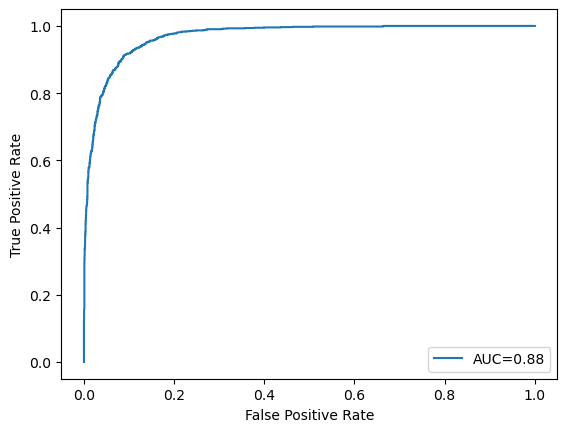

Model: f1 = 0.833 roc_auc = 0.877


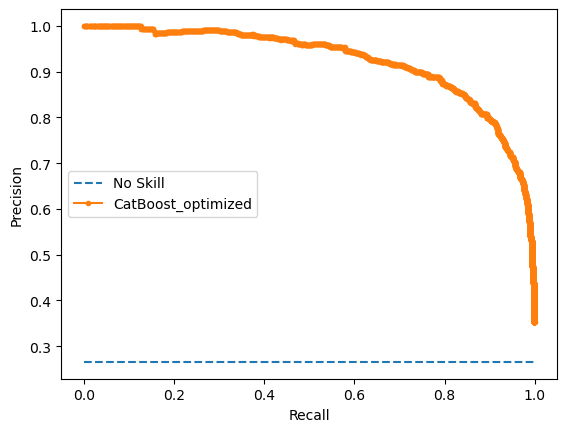


 50%|█████     | 1/2 [00:02<00:02,  2.06s/it]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


ROC/AUC: 0.6971471947792985
Accuracy: 0.7913259864912905
F1 score: 0.5583145221971406
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2065
           1       0.64      0.50      0.56       748

    accuracy                           0.79      2813
   macro avg       0.73      0.70      0.71      2813
weighted avg       0.78      0.79      0.78      2813

[[1855  210]
 [ 377  371]]


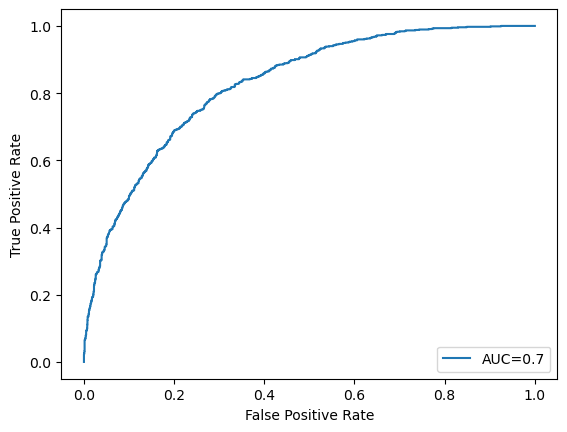

Model: f1 = 0.558 roc_auc = 0.697


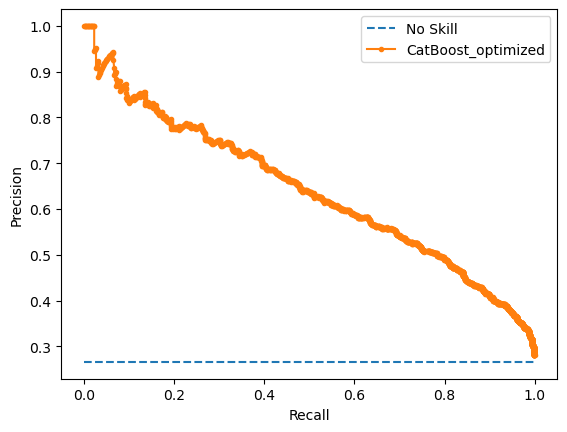


  0%|          | 0/2 [00:00<?, ?it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


ROC/AUC: 0.7805985732788383
Accuracy: 0.7672434226119934
F1 score: 0.6487839771101575
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      3098
           1       0.54      0.81      0.65      1121

    accuracy                           0.77      4219
   macro avg       0.73      0.78      0.74      4219
weighted avg       0.82      0.77      0.78      4219

[[2330  768]
 [ 214  907]]


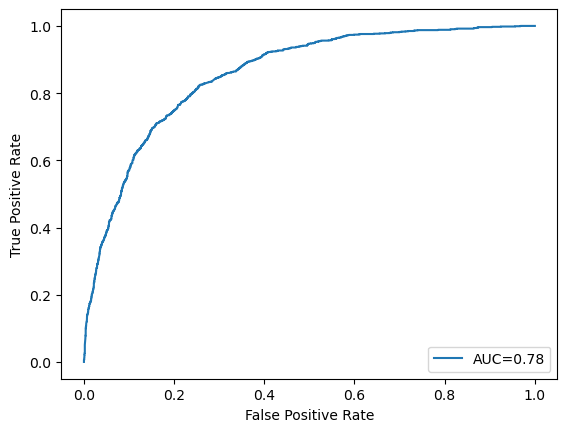

Model: f1 = 0.649 roc_auc = 0.781


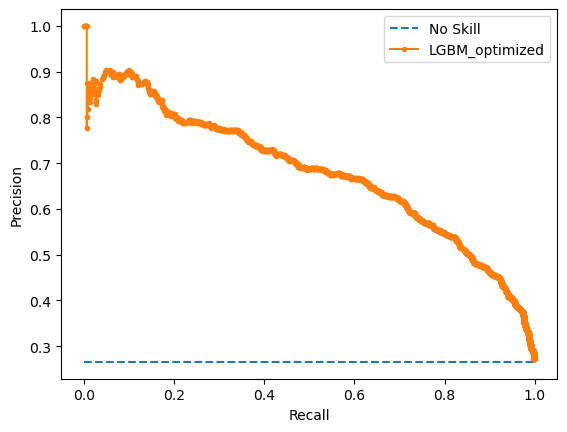


 50%|█████     | 1/2 [00:00<00:00,  1.85it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


ROC/AUC: 0.761113736711942
Accuracy: 0.7575542125844295
F1 score: 0.6277292576419213
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      2065
           1       0.53      0.77      0.63       748

    accuracy                           0.76      2813
   macro avg       0.72      0.76      0.72      2813
weighted avg       0.80      0.76      0.77      2813

[[1556  509]
 [ 173  575]]


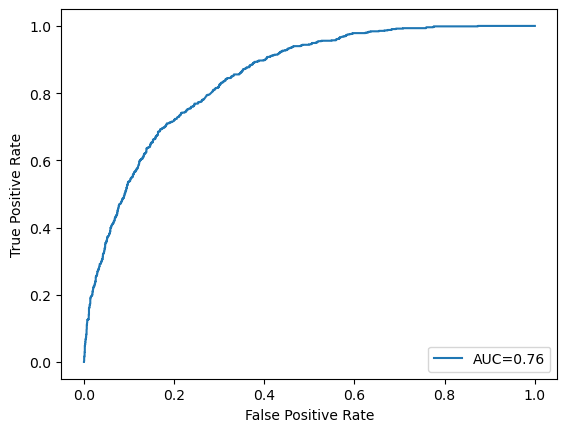

Model: f1 = 0.628 roc_auc = 0.761


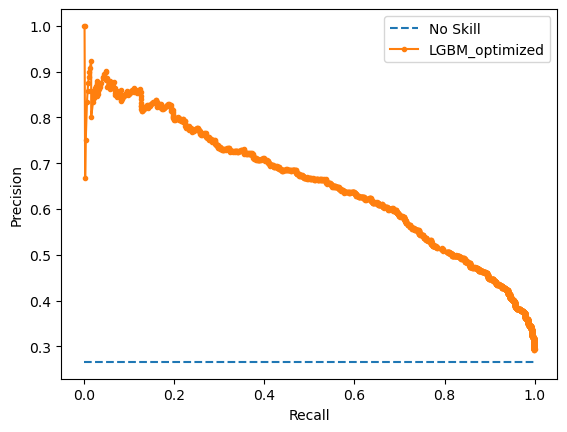


100%|██████████| 2/2 [00:03<00:00,  1.80s/it]


In [188]:
###########################################
### Assess the performance of the model ###
###########################################

models_optimized = [('CatBoost_optimized', cboost_model_hy),
                    ('LGBM_optimized', lbgm_model_hy)]

dset = [('Training', X_train_mod, y_train),
        ('Test', X_test_mod, y_test)]

results_fin = pd.DataFrame(columns = ['Model','Metrics','Training','Test'])

for name, model in tqdm(models_optimized):

    results = pd.DataFrame(['ROC/AUC:','Accuracy:','F1 score:'],
                           columns = ['Metrics'])

    for name_dset, X_dset, y_dset in tqdm(dset):

        #####################
        ### Fit the model ###
        #####################

        if name != 'LGBM_optimized':

            if name_dset == 'Training':
                model.fit(X_dset, y_dset)

            y_pred_p = model.predict_proba(X_dset)
            y_pred_p1 = y_pred_p[:,1]

        y_pred_hyp = model.predict(X_dset)
        if name == 'LGBM_optimized':
            y_pred_p1 = pd.DataFrame(y_pred_hyp)
            y_pred_hyp = np.rint(y_pred_hyp)

        metric = []
        roc_auc_hyp = roc_auc_score(y_dset, y_pred_hyp)
        metric.append(roc_auc_hyp)
        accuracy_hyp = accuracy_score(y_dset, y_pred_hyp)
        metric.append(accuracy_hyp)
        f1_score_hyp = metrics.f1_score(y_dset, y_pred_hyp)
        metric.append(f1_score_hyp)

        print('ROC/AUC:', roc_auc_hyp)
        print('Accuracy:', accuracy_hyp)
        print('F1 score:', f1_score_hyp)

        print(classification_report(y_dset, y_pred_hyp))

        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_dset, y_pred_hyp)

        cm_as_df = cm2df(cm,['Not churn','Churn'])

        print(confusion_matrix(y_dset, y_pred_hyp))

        results = pd.concat([results,
                             pd.DataFrame(metric,
                                          columns = [name_dset])],
                            axis = 1)

        #################
        ### ROC curve ###
        #################

        fpr, tpr, _ = metrics.roc_curve(y_dset,  y_pred_p1)

        plt.plot(fpr,
                 tpr,
                 label = "AUC=" + str(round(roc_auc_hyp,2)))
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc=4)
        plt.show()

        roc_data = pd.concat([pd.DataFrame(fpr),
                              pd.DataFrame(tpr)],axis = 1)
        roc_data.columns = ['FPR','TPR']
        roc_data = roc_data.reset_index()

        ###############################
        ### Precision Recall curves ###
        ###############################

        precision, recall, thresholds = precision_recall_curve(y_dset,
                                                               y_pred_p1)

        ### calculate F1 score ###

        f1 = metrics.f1_score(y_dset, y_pred_hyp)

        ### summarize scores ###

        print('Model: f1 = %.3f roc_auc = %.3f' % (f1, roc_auc_hyp))

        ### plot the precision-recall curves ###

        no_skill = len(y_dset[y_dset == 1]) / len(y_dset)

        plt.plot([0, 1],
                 [no_skill, no_skill],
                 linestyle='--',
                 label='No Skill')
        plt.plot(recall,
                 precision,
                 marker='.',
                 label = name)
        plt.xlabel('Recall')
        plt.ylabel('Precision')

        ### show the legend ###
        plt.legend()
        plt.show()

        pr_data = pd.concat([pd.DataFrame(precision),
                              pd.DataFrame(recall)],axis = 1)
        pr_data.columns = ['Precision','Recall']
        pr_data = pr_data.reset_index()

        results['Model'] = name

    results_fin = pd.concat([results_fin,
                             results],
                            axis = 0)

### Shapley values

In [189]:
explainer = shap.TreeExplainer(lbgm_model_hy)
shap_values = explainer.shap_values(X_train_mod)

# visualize the first prediction's explanation 
shap.initjs()

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


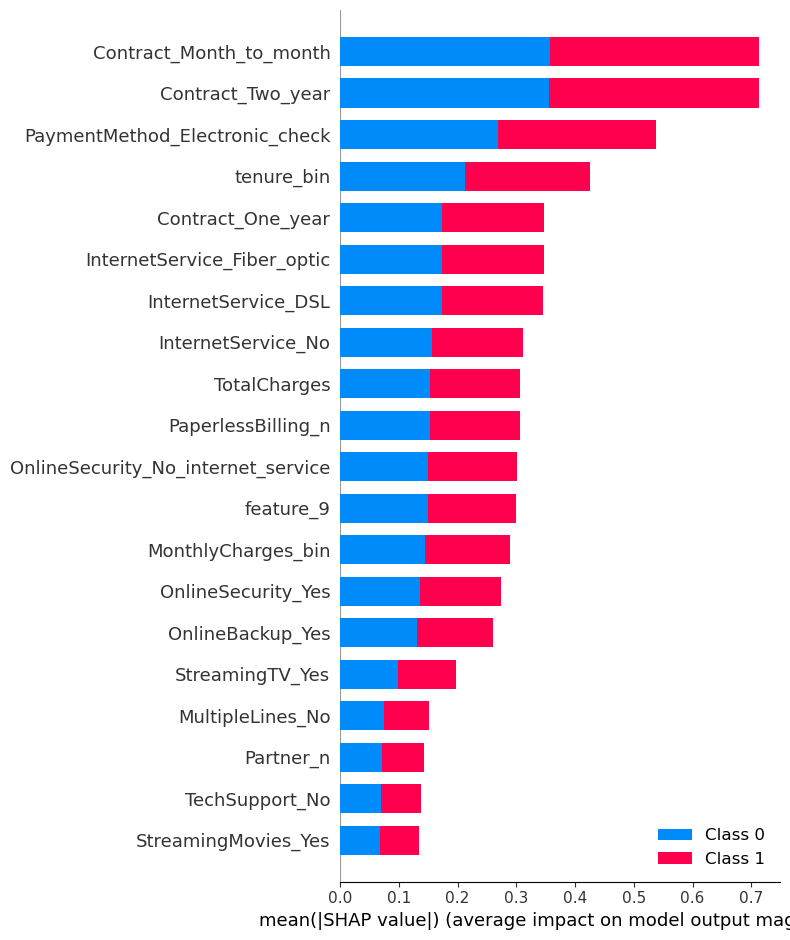

In [190]:
shap_values = shap.TreeExplainer(lbgm_model_hy).shap_values(X_train_mod)
shap.summary_plot(shap_values, X_train_mod, plot_type="bar");

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


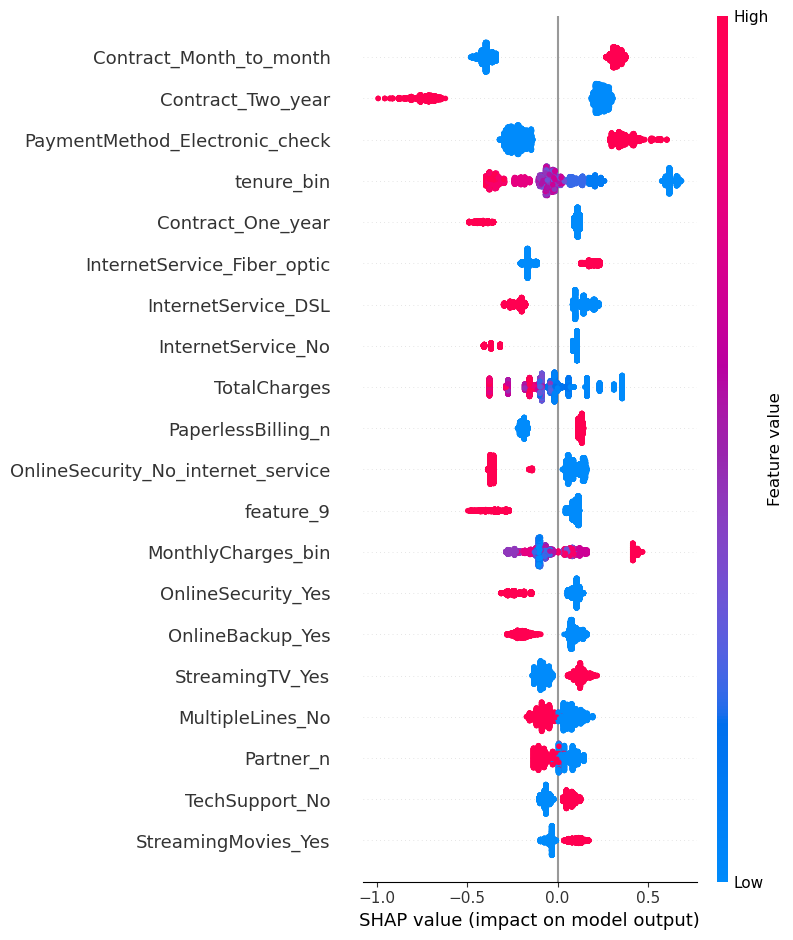

In [191]:
shap.summary_plot(shap_values[1], X_train_mod, plot_type='dot')